<font color='DarkBlue' size=+2><b>Комментарий ревьюера</b></font><br>
<font color='DarkBlue'>Привет, Александра! <br>Меня зовут Олег Мазуренко, и я буду проверять этот проект. Спасибо за проделанную работу! <br>Ко мне можно обращаться на «ты». Как мне обращаться, напиши.</font><br>
<font color='DarkBlue'>Я буду использовать различные цвета, чтобы было удобнее воспринимать мои комментарии:</font><br>
<font color='DarkBlue'>Синий текст &mdash; просто текст комментария.</font><br>
<font color='DarkGreen'>👌 Зеленый текст &mdash; все отлично.</font><br>
<font color='DarkMagenta'>👉 Фиолетовый текст &mdash; сделано все правильно, однако есть рекомендации, на что стоит обратить внимание. Реализованные рекомендации позволят нам наработать опыт решения задачи разными способами или посмотреть на задачу под иным углом.</font><br>
<font color='Red'>🛠 Красный текст &mdash; есть недочеты, они иногда бывают. </font><br><font color='DarkBlue'>Любая ошибка это возможность посмотреть на задачу с другой стороны и освоить новые знания, по этому не надо расстраиваться, если они есть.</font><br>
<font color='DarkBlue'>Обращаю внимание, что комментарии ревьюера после проверки удалять нельзя они помогают отследить логику исправления или изменения проекта. Это дополнительный навык при обучении. Свой исправляемый код лучше тоже не удалять, а ремить #, это позволит акцентировать изменения в ходе подготовки окончательного варианта проекта.<br>
Ответы на мои комментарии лучше тоже помечать. 
Например: </font><font color='Blue'><b>Комментарий студента</b></font><br>
<font color='DarkBlue'><b>Теперь посмотрим, что у нас получилось!</b></font>

</font><font color='Blue'><b>Комментарий студента</b></font><br>

Привет, Олег! Большое спасибо! Постаралась исправить проект по комментариям.

<font color='DarkBlue'><b>Комментарий ревьюера 2</b></font><br>
<font color='DarkGreen'>👌 Привет! Хорошо, пошел смотреть обновленный проект.</font>

# Определение факторов, влияющих на успешность компьютерных игр интернет-магазина

Интернет-магазин «Стримчик» продаёт по всему миру компьютерные игры.

**Цель исследования:**
на основе исторических данных о продажах и рейтинге игр выявить закономерности, определяющие успешность игры, с целью планирования дальнейших рекламных кампаний.

**Описание данных:**

-	*Name* — название игры
-	*Platform* — платформа
-	*Year_of_Release* — год выпуска
-	*Genre* — жанр игры
-	*NA_sales* — продажи в Северной Америке (миллионы проданных копий)
-	*EU_sales* — продажи в Европе (миллионы проданных копий)
-	*JP_sales* — продажи в Японии (миллионы проданных копий)
-	*Other_sales* — продажи в других странах (миллионы проданных копий)
-	*Critic_Score* — оценка критиков (максимум 100)
-	*User_Score* — оценка пользователей (максимум 10)
-	*Rating* — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkMagenta'>👉 Было бы правильно добавить план исследования в описание проекта.</font>

</font><font color='Blue'><b>Комментарий студента</b></font><br>

План исследования добавлен ниже.

**План исследования:**
1. Загрузка данных.
2. Предобработка данных (обработка названий переменных, проверка дубликатов, замена типа данных, обработка пропущенных значений, добавление новых переменных).
3. Исследовательский анализ (распределение и взаимосвязь переменных).
4. Формирование портретов пользователей по регионам (популярные платформы, жанры и рейтинг компьютерных игр).
5. Статистический анализ (проверка гипотез).

<font color='DarkBlue'><b>Комментарий ревьюера 2</b></font><br>
<font color='DarkGreen'>👌 Все проекты, это как часть реального исследования, за которое деньги заплатят или не заплатят. <br>А отчет читают: сначала описание, о чем идет речь и что делаем, потом выводы: что в итоге получили. А когда у заказчика в голове все сложилось, то смотрят как это делалось. То есть, в описании необходимо отразить какая цель исследования, какой контекст (особенности отрасли и данных), что мы планируем делать (план исследования). <br>И в реальном проекте не будет инструкции и задач, которые необходимо выполнить, по этому следует научиться делать описание проекта самостоятельно.</font>

</font><font color='Blue'><b>Комментарий студента 2</b></font><br>

Хорошо, спасибо!

## Загрузка данных

In [1]:
# импортируем библиотеки

import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats as st
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
# загрузим файл с данными и посмотрим общую информацию о датасете

try:
    data = pd.read_csv('/datasets/games.csv')
except:
    data = pd.read_csv('C:/Users/Александра/practicum/datasets/games.csv')
    
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkGreen'>👌 Очень хорошо, что используется код двойной загрузки, локально и с сервера. Часто в проектах возникают ошибки именно из-за не правильного пути к датасету.</font>

</font><font color='Blue'><b>Комментарий студента</b></font><br>

Благодарю!

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
data.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

В загруженном датасете имеются **16 715 наблюдений** по **11 переменным**. По переменным *Name*, *Year_of_Release*, *Genre*, *Critic_Score*, *User_Score* и *Rating* имеются пропущенные значения, которые предстоит обработать на следующем этапе исследования.

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkGreen'>👌 Хорошо, изучили данные для предобработки.</font>

## Предобработка данных

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='Red'>🛠 Просмотрел весь раздел, но не нашел проверки явных дубликатов. Если мы это сделали, но потом код удалили, то это не совсем правильно, пусть все знают, что мы тщательно анализируем данные.</font><br>
<font color='Red'>🛠 Так же не произведена проверка неявных дубликатов и не принято решение по их обработке. Данная проверка является составной частью первичного анализа данных. Проверять лучше по имени, платформе и году релиза одновременно.</font>

</font><font color='Blue'><b>Комментарий студента</b></font><br>

Проверки на наличие дубликатов действительно не было - она добавлена в п 2.2.

Не поняла момент: "Проверять лучше по имени, платформе и году релиза одновременно":
1. в переменной, содержащей имя игры, слишком много уникальных значений - поиск неявных дубликатов в них может быть затруднён. Единственный способ, который сейчас вижу: привести все названия к нижнему регистру и посмотреть, изменилось ли количество уникальных значений (оно не изменилось - в п. 2.2 проверила).
2. как можно осуществить поиск неявных дубликатов по нескольким переменным одновременно?

<font color='DarkBlue'><b>Комментарий ревьюера 2</b></font><br>
<font color='DarkMagenta'>👉 В метод необходимо передать список колонок. И ответы такие вопросы необходимо находить или в технической документации по данному методу или задавать вопрос преподавателю, так как формат ревью не предполагает интерактивной коммуникации.</font>

</font><font color='Blue'><b>Комментарий студента 2</b></font><br>

Поняла, хорошо!

### Замена названий столбцов

In [5]:
# приведём все названия переменных к нижнему регистру

data.columns = data.columns.str.lower()
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkGreen'>👌 Молодец! 👍 Иногда пишут длинный словарь для замены колонок, как в проекте по музыке.</font>

### Проверка на наличие дубликатов

In [6]:
data.duplicated().sum()

0

**Явных дубликатов в датафрейме не обнаружено.**

Проверим датафрейм на наличие неявных дубликатов по переменным *name*, *platform* и *genre*.

In [7]:
# проверим количество уникальных значений по переменной name

# data['name'].nunique()

In [8]:
# понизим регистр всех значений в переменной name 
# и проверим новое количество уникальных значений

# data['name'] = data['name'].str.lower()
# data['name'].nunique()

In [9]:
# data['platform'].value_counts()

In [10]:
# data['genre'].value_counts()

<font color='DarkBlue'><b>Комментарий ревьюера 2</b></font><br>
<font color='DarkMagenta'>👉 Так неявные дубликаты не найти, я же писал, что надо искать одновременно по трем колонкам.</font>

In [11]:
# Комментарий ревьюера 2
temp = data.copy()
temp[temp[['name', 'platform','year_of_release']].duplicated(keep=False)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.00,0.23,83.0,5.5,E
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN
16230,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.00,0.00,83.0,5.5,E


<font color='DarkBlue'><b>Комментарий ревьюера 2</b></font><br>
<font color='DarkMagenta'>👉 Вот они неявные дубликаты.</font>

</font><font color='Blue'><b>Комментарий студента 2</b></font><br>

Спасибо! Воспользовалась этим методом ниже и отредактировала вывод.

In [12]:
#data[data.duplicated(subset=['name', 'platform', 'genre'], keep=False)]

По переменных *name*, *platform* и *genre* были выявлены неявные дубликаты, поэтому от них необходимо избавиться.

In [13]:
#data = data.drop_duplicates(subset=['name', 'platform', 'genre'])
#data.info()

<font color='DarkBlue'><b>Комментарий ревьюера 3</b></font><br>
<font color='DarkMagenta'>👉 А вот это не корректно, так как некоторые игры под одним именем выходили в разные года на одинаковых платформах.</font>

</font><font color='Blue'><b>Комментарий студента 3</b></font><br>

Смотрела дубликаты по жанру вместо года =/ Исправила ниже.

In [14]:
data[data.duplicated(subset=['name', 'platform', 'year_of_release'], keep=False)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.00,0.23,83.0,5.5,E
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN
16230,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.00,0.00,83.0,5.5,E


In [15]:
data = data.drop_duplicates(subset=['name', 'platform', 'year_of_release'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16712 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16712 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8136 non-null   float64
 9   user_score       10013 non-null  object 
 10  rating           9948 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


После проверки на дубликаты в датасете осталось **16 713 записей**.

### Замена типа данных

In [16]:
# изучим тип данных по переменным датафрейма

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16712 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16712 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8136 non-null   float64
 9   user_score       10013 non-null  object 
 10  rating           9948 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


Отметим следующие изменения, которые необходимо произвести:
1. *year_of_release*: float64 -> int64. Причина: год выхода игры - это целочисленное значение.
2. *user_score*: object -> float64. Причина: оценка пользователей - это не строковая, а количественная переменная, измеряющаяся от 0 до 10.

#### year_of_release

In [17]:
# заменим тип данных переменной year_of_release

data['year_of_release'] = data['year_of_release'].astype('Int64')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16712 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16712 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8136 non-null   float64
 9   user_score       10013 non-null  object 
 10  rating           9948 non-null   object 
dtypes: Int64(1), float64(5), object(5)
memory usage: 1.5+ MB


<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkGreen'>👌 Хорошо, что перевели тип данных по году выпуска игр. 👍</font>

#### user_score

In [18]:
# изучим список уникальных значений по переменной user_score

data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Стало понятно, почему тип данных по переменной *user_score* был определён как *object*: среди значений встречаются не только вещественные числа, но и такое значение, как "tbd". Вероятно, оно расшифровывается как "to be determined", т.е. оценка пользователей для этой игры ещё не была выставлена (например, по причине того, что игра вышла недавно, или опрос пользователей ещё не завершён).

Изучим, сколько таких записей присутствует в выборке.

In [19]:
print('В выборке наблюдается', data[data['user_score'] == 'tbd']['user_score'].count(), \
      'записи, в которых переменная user_score принимает значение "tbd".')

В выборке наблюдается 2424 записи, в которых переменная user_score принимает значение "tbd".


Проверим, в какие года были выпущены игры, по которым переменная *user_score* принимает значение "tbd".

**Предположение**: игры, которые вышли незадолго до 2016 года, ещё не были оценены пользователями, поэтому переменная *user_score* приняла значение "tbd".

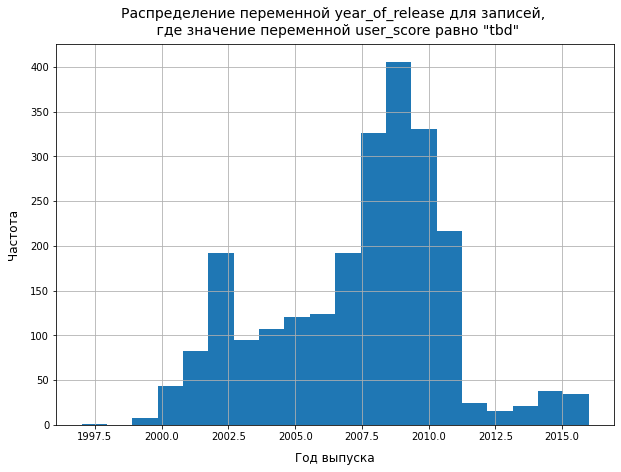

In [20]:
data.loc[data['user_score'] == 'tbd', 'year_of_release'].hist(figsize=(10,7), bins=20)
plt.title('Распределение переменной year_of_release для записей, \n где значение переменной \
user_score равно "tbd"', fontsize=14, pad=10)
plt.xlabel('Год выпуска', fontsize=12, labelpad=10)
plt.ylabel('Частота', fontsize=12, labelpad=10)
None

Предположение не было подтверждено. Игры, у которых значение *user_score* равно "tbd", могли быть выпущены как в 2000, так и в 2015 году.

Проверим другое **предположение**: такое значение переменная принимает в том случае, если продажи игры были слишком малы для того, чтобы сформировать оценку от пользователей.

In [21]:
(data.
 pivot_table(
     index='user_score',
     values=['na_sales', 'eu_sales', 'jp_sales', 'other_sales'],
     aggfunc='median'
))

,eu_sales,jp_sales,na_sales,other_sales
user_score,,,,
0,0.000,0.000,0.660,0.060
0.2,0.010,0.000,0.055,0.010
0.3,0.005,0.000,0.155,0.010
0.5,0.010,0.000,0.105,0.005
0.6,0.000,0.000,0.055,0.005
...,...,...,...,...
9.4,0.170,0.150,0.470,0.010
9.5,0.010,0.000,0.080,0.005
9.6,0.085,0.055,0.220,0.005


Предположение также не оправдалось. По всей видимости, при заполнении базы имела место ошибка, поэтому с целью дальнейшего анализа заменим все значения "tbd" в переменной *user_score* на пропущенные значения (NaN).

Избавляться от таких данных не стоит, т.к. они составляют ~ 14.5% всей выборки, что будет слишком много для удаления.

In [22]:
data['user_score'] = data['user_score'].replace('tbd', np.nan)
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', '8.8', '6.9', '9.4', '6.8', '6.1',
       '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6', '3.7',
       '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9', '3.1',
       '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3', '2.7',
       '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0', '1.6',
       '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2', '2.3',
       '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'], dtype=object)

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkGreen'>👌 Правильно сделана замена "tbd" на NaN. Это практически аналог пропусков.</font>

Можно отметить, что значение "tbd" исчезло из списка уникальных значений переменной *user_score*. Заменим тип *object* на *float64*.

In [23]:
data['user_score'] = data['user_score'].astype('float64')
data['user_score'].describe()

count    7589.000000
mean        7.125260
std         1.499989
min         0.000000
25%         6.400000
50%         7.500000
75%         8.200000
max         9.700000
Name: user_score, dtype: float64

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16712 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16712 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8136 non-null   float64
 9   user_score       7589 non-null   float64
 10  rating           9948 non-null   object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.5+ MB


После замены все переменные имеют необходимый тип данных - можно переходить к обработке пропущенных значений.

### Обработка пропущенных значений

In [25]:
# выведем список переменных и количество пропущенных значений по ним

data.isna().sum()

name                  1
platform              0
year_of_release     269
genre                 1
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8577
user_score         9124
rating             6765
dtype: int64

Необходимо обработать пропущенные значения по переменным:
1. *year_of_release*;
2. *critic_score*;
3. *user_score*;
4. *rating*.

По переменным *name* и *genre* всего по 2 пропуска - кроме того, эти столбцы не играют ключевую роль в анализе. Следовательно, мы можем оставить пропущенные значения в этих переменных.

#### year_of_release

In [26]:
# выведем количество пропущенных значений по переменной

data['year_of_release'].isna().sum()

269

In [27]:
# изучим распределение переменной year_of_release

#data['year_of_release'].hist(bins=30, figsize=(10, 7))
#plt.title('Распределение переменной year_of_release', fontsize=14, pad=10)
#plt.xlabel('Год выпуска', fontsize=12, labelpad=10)
#plt.ylabel('Частота', fontsize=12, labelpad=10)
#None

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='Red'>🛠 Для того, что бы гистограмма отражала выпуск игр по годам надо подобрать параметр `bins` равный количеству годов релиза в нашем датасете, только надо учитывать первый и последний года релиза в этом диапазоне. Тогда не будет пиков на графике. </font>

</font><font color='Blue'><b>Комментарий студента</b></font><br>

Ниже построила график с новым количеством корзин (вместо 30 - 37, т.е. количество уникальных значений по переменной *year_of_release*).

In [28]:
data['year_of_release'].nunique()

37

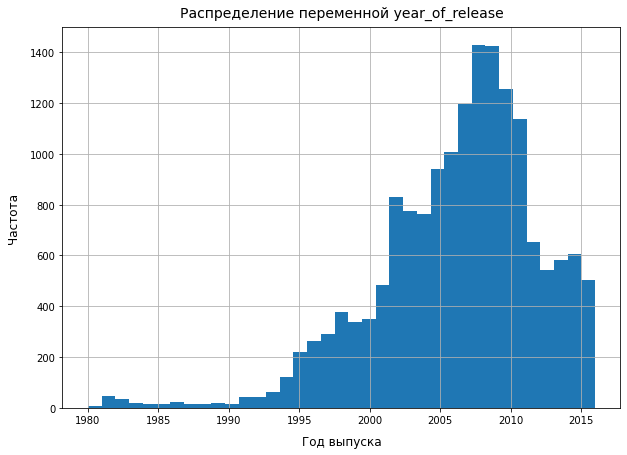

In [29]:
# изучим распределение переменной year_of_release

data['year_of_release'].hist(bins=37, figsize=(10, 7))
plt.title('Распределение переменной year_of_release', fontsize=14, pad=10)
plt.xlabel('Год выпуска', fontsize=12, labelpad=10)
plt.ylabel('Частота', fontsize=12, labelpad=10)
None

<font color='DarkBlue'><b>Комментарий ревьюера 2</b></font><br>
<font color='DarkGreen'>👌 Красивые и информативные графики всегда приветствуются, особенно когда на них есть все подписи осей, названия меток и название графика. Как правило, заказчик не является аналитиком и ему трудно по коду разбираться, что изображено на диаграммах. Кроме того, в презентацию реального проекта в основном идут именно скрины графиков, таблицы мало информативны. По этому необходимо сразу графики максимально описывать.</font>

</font><font color='Blue'><b>Комментарий студента 2</b></font><br>

Хорошо, большое спасибо за совет!

Заполнение пропущенных значений по переменной *year_of_release* средним или медианным значением будет грубым приближением - мы не можем с уверенностью утверждать, что игры, по которорым не был указан год выпуска, были выпущены примерно в тот же год, который представляет среднее или медианное значение по всей выборке.

**Предположение**: год выпуска можно считать общей характеристикой для игр, выпущенных на одной и той же платформе.

Проверим это предположение и при его подтверждении - заполним пропуски по переменной *year_of_release* медианными значениями этой переменной в группировке по переменной *platform* (кроме того, по последней нет пропусков данных).

In [30]:
# выведем перечень уникальных значений переменной platform

#data['platform'].value_counts()

In [31]:
# изучим среднее, медианное, минимальное и максимальное значения года выпуска игры 
# в зависимости от платформы

#pivot = data.pivot_table(
#    index='platform',
#    values='year_of_release',
#    aggfunc=['mean', 'median', 'min', 'max'])

#pivot.columns = pivot.columns.droplevel()
#pivot.columns = ['mean', 'median', 'min', 'max']
#pivot = pivot.sort_values(by=['median'], ascending=False)
#cm = sns.light_palette("green", as_cmap=True)
#pivot = pivot.style.background_gradient(cmap=cm)
#pivot

В целом заметен **тренд**: на определённых платформах игры выпускались раньше, на других - позже. Заменим пропущенные значения переменной *year_of_release* на медианное значение года выпуска в разбивке по платформе.

In [32]:
#median_table = np.rint(data.groupby('platform')['year_of_release'].transform('median'))
#data['year_of_release'] = data['year_of_release'].fillna(median_table)
#data.isna().sum()

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='Red'>🛠 А зачем получать среднюю "температуру" по "больнице" по пропускам года релиза когда их всего 1,6%. Удалить их и забыть.</font>

</font><font color='Blue'><b>Комментарий студента</b></font><br>

Принято! Заремила код выше и удалила записи с пропущенными значениями по *year_of_release*.

In [33]:
print('По переменной year_of_release в датасете пропущено',
      data['year_of_release'].isna().sum(), 'значений, что составляет',
      round(data['year_of_release'].isna().sum()/data.shape[0] * 100, 1),
      '% от общей выборки.')

По переменной year_of_release в датасете пропущено 269 значений, что составляет 1.6 % от общей выборки.


Т.к. доля пропущенных значений по переменной *year_of_release* составляет 1.6% от всей выборки, от таких записей можно избавиться.

In [34]:
data = data.dropna(subset=['year_of_release'])
data['year_of_release'].isna().sum()

0

<font color='DarkBlue'><b>Комментарий ревьюера 2</b></font><br>
<font color='DarkGreen'>👌 Почему удаляем год релиза и когда, что удалять. В реальности все зависит от поставленной задачи на исследование. В данном проекте необходимо определить актуальный период, на основании которого мы и будем делать прогнозы на 2017 год. Соответственно, мы все равно будем сокращать датасет, фильтруя по году релиза. А можно провести анализ, сколько пропусков года релиза приходится на платформы, которые например к 2000 году уже вышли с рынка, то есть для прогноза на 2017 год мы их явно учитывать не будем.</font>

</font><font color='Blue'><b>Комментарий студента 2</b></font><br>

Спасибо!

#### critic_score и user_score

Большое количество пропусков данных по оценкам критиков - существенное препятствие для дальнейшего анализа.

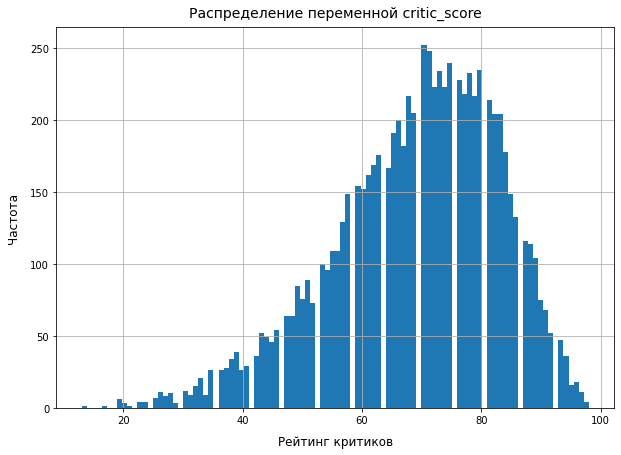

In [35]:
# изучим распределение переменных critic_score и user_score

data['critic_score'].hist(bins=100, figsize=(10, 7))
plt.title('Распределение переменной critic_score', fontsize=14, pad=10)
plt.xlabel('Рейтинг критиков', fontsize=12, labelpad=10)
plt.ylabel('Частота', fontsize=12, labelpad=10)
None

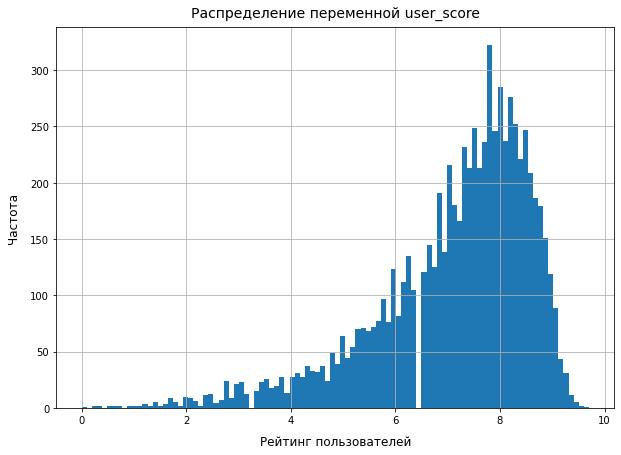

In [36]:
data['user_score'].hist(bins=100, figsize=(10, 7))
plt.title('Распределение переменной user_score', fontsize=14, pad=10)
plt.xlabel('Рейтинг пользователей', fontsize=12, labelpad=10)
plt.ylabel('Частота', fontsize=12, labelpad=10)
None

Распределение переменных *critic_score* и *user_score* напоминает нормальное со сдвигом вправо. Проверим, связаны ли эти оценки между собой.

0.58


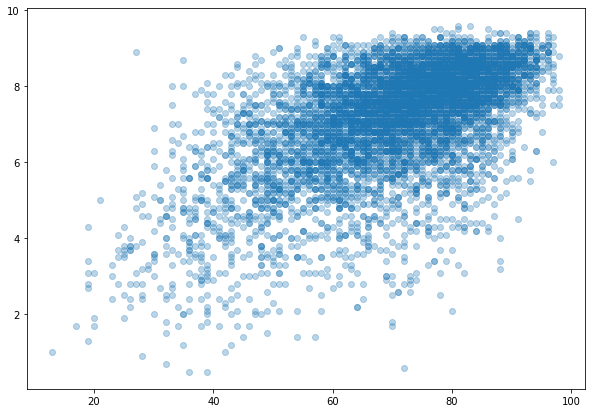

In [37]:
plt.figure(figsize=(10, 7))
plt.scatter(data['critic_score'], data['user_score'], alpha=0.3)
print(round(data['critic_score'].corr(data['user_score']), 2))
None

Между переменными наблюдается средняя взаимосвязь, что также подтверждается коэффициентом корреляции на уровне 0.58.

Тем не менее, ввиду того, что по переменной *user_score* также наблюдается много пропущенных значений, мы не можем использовать медианные значения этой переменной для заполнения пропущенных значений переменной *critic_score* (и наоборот).

Удалять записи с пропущенными значениями - также не выход, т.к. подобные наблюдения составляют большую долю датафрейма. Поэтому для дальнейшего анализа **оставим пропущенные значения переменных *critic_score* и *user_score***.

#### rating

In [38]:
# изучим уникальные значения переменной rating и количество пропусков по ней

print('Уникальные значения переменной rating:')
print(data['rating'].value_counts())
print()
print('Количество пропущенных значений:', data['rating'].isna().sum())

Уникальные значения переменной rating:
E       3920
T       2905
M       1536
E10+    1393
EC         8
K-A        3
RP         1
AO         1
Name: rating, dtype: int64

Количество пропущенных значений: 6677


**Предположение**: возрастной рейтинг игры коррелирует с её жанром.

Проверим это предположение с помощью частотной таблицы.

In [39]:
crosstab = pd.crosstab(index=data['genre'], columns=data['rating'])
crosstab['sum'] = crosstab.sum(axis=1)
crosstab = crosstab.sort_values(by=['sum'], ascending=False)
cm = sns.light_palette("green", as_cmap=True)
crosstab = crosstab.style.background_gradient(cmap=cm)
crosstab

rating,AO,E,E10+,EC,K-A,M,RP,T,sum
genre,,,,,,,,,
Action,1,410,468,1,0,596,0,670,2146
Sports,0,1161,105,0,0,16,0,195,1477
Shooter,0,47,56,0,0,553,0,340,996
Misc,0,449,166,5,1,13,0,228,862
Racing,0,576,95,0,0,18,0,167,856
Role-Playing,0,83,111,0,0,161,0,415,770
Platform,0,354,141,0,0,3,0,63,561
Simulation,0,321,47,0,0,5,0,186,559
Adventure,0,159,67,2,0,98,0,114,440


In [40]:
data['rating'].corr(data['genre'], method='spearman')

-0.17091391991680044

<font color='DarkBlue'><b>Комментарий ревьюера 2</b></font><br>
<font color='DarkGreen'>👌 Когда выскакивают предупреждения, это означает, что в будущей новой версии библиотеки применяемый метод обработки будет не применим. Если мы планируем данный код использовать в будущем, то надо разобраться и изменить код. Если нам он в будущем не понадобится, то можно принудительно запретить вывод предупреждений вставив в ячейку с библиотеками вот такой код: <br>`pd.set_option('chained_assignment', None)` или такой: <br></font>
`import warnings`<br>
`warnings.filterwarnings("ignore")`

</font><font color='Blue'><b>Комментарий студента 2</b></font><br>

Благодарю! Вставила один из вариантов в ячейку загрузки библиотек.

Предположение не подтвердилось: возрастной рейтинг игры слабо связан с её жанром.

Удалить все записи, в которых пропущены значения по переменной *rating*, будет ошибкой ввиду потери слишком большой части выборки.

Про рейтинг ESRB известно, что он назначается для игр в США и Канаде, а в Европе и Японии есть другие организации, определяющие рейтинг компьютерной игры. Предположительно, пропуски значений по переменной rating обусловлен тем, что игра была издана не в США и Канаде. Следовательно, на такие значения целесообразно поставить заглушку, которая будет нести в себе эту информацию.

In [41]:
data['rating'] = data['rating'].fillna('NonNA')
data['rating'].value_counts()

NonNA    6677
E        3920
T        2905
M        1536
E10+     1393
EC          8
K-A         3
RP          1
AO          1
Name: rating, dtype: int64

#### Возможные причины появления пропусков

Что могло привести к пропускам значений по переменным *critic_score*, *user_score* и *rating*?

**1. critic_score**

Наличие 8 578 пропусков по переменной *criric_score* (51.3% от всей выборки) может быть обусловлено следующими факторами:
- недостаточное количество оценок от критиков для формирования рейтинга;
- низкие продажи игры - как следствие, непрохождение минимального количества продаж для направления игры на оценку критиков;
- технические ошибки при выгрузке или переносе данных.

**2. user_score**

Из 9 125 пропущенных значений по переменной *user_score* 2 424 ранее принимали значение "tbd" (25.6% от всех пропущенных значений по переменной). Остальные пропуски могли появиться по следующим причинам:
- недостаточное количество оценок от пользователей для формирования рейтинга;
- технические ошибки при выгрузке или переносе данных.

**3. rating**
- рейтинг ESRB назначается для игр в США и Канаде. В Европе и Японии есть свои рейтинги для компьютерных игр (PEGI и CERO). Вероятно, пропуск рейтинга ESRB у игры означает то, что она была издана не в США или Канаде;
- технические ошибки при выгрузке или переносе данных.

<font color='DarkBlue'><b>Комментарий ревьюера 2</b></font><br>
<font color='DarkMagenta'>👉 Анализ причин пропусков позволяет нам принять правильное решение по их обработке.</font>

</font><font color='Blue'><b>Комментарий студента 2</b></font><br>

Если правильно поняла, то из обозначенных выше причин пропусков можем сделать вывод как раз про рейтинг ESRB - и про то, что данные с заглушкой также следует брать во внимание.

<font color='DarkBlue'><b>Комментарий ревьюера 3</b></font><br>
<font color='DarkGreen'>👌 Верно.</font>

### Добавление столбцов

In [42]:
# добавим в датафрейм столбец с суммарными продажами во всех регионах

data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16443 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7982 non-null   float64
 9   user_score       7462 non-null   float64
 10  rating           16444 non-null  object 
 11  total_sales      16444 non-null  float64
dtypes: Int64(1), float64(7), object(4)
memory usage: 1.6+ MB


<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkGreen'>👌 Молодец, не забыли создать колонку с общими продажами. 👍 <br> А можно использовать вот такой код:</font><br>
`= data.loc[:,['na_sales','eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)`

</font><font color='Blue'><b>Комментарий студента</b></font><br>

Спасибо! Протестировала этот вариант - всё сработало :)

In [43]:
#data['total'] = data.loc[:, ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)
#data

После проведённой предобработки данных можно приступить к исследовательскому анализу.

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='Red'>🛠 Вот, что написано в задании: <br><b>
Опишите причины, которые могли привести к пропускам</b> <br>А это не сделано.</font><br>
<font color='Red'>🛠 Раздел предобработки данных должен заканчиваться выводами по проведенному анализу и обработке данных.</font>

</font><font color='Blue'><b>Комментарий студента</b></font><br>

Добавила возможные причины появления пропусков в п. 2.4.4, а результаты предобработки данных - в п 2.6.

In [44]:
# Комментарий ревьюера
# Посмотрим, что осталось
temp = data.copy() 
list_c = ['name', 'platform', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating']
print(temp.info())
for col_l in list_c:
  print('-'* 25)
  print(col_l, temp[col_l].sort_values().unique())
  print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().mean()*100,2),'%') 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16443 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7982 non-null   float64
 9   user_score       7462 non-null   float64
 10  rating           16444 non-null  object 
 11  total_sales      16444 non-null  float64
dtypes: Int64(1), float64(7), object(4)
memory usage: 1.6+ MB
None
-------------------------
name [' Beyblade Burst' ' Fire Emblem Fates' " Frozen: Olaf's Quest" ...
 'uDraw Studio: Instant Artist' '¡Shin Chan Flipa en colores!' nan]
name : кол-во

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkMagenta'>👉 Я бы порекомендовал посмотреть в инете, что означает рейтинг ESRB. И пропуски в этой колонке не являются просто ошибкой заполнения данных, а несут определенную информацию. Чтобы проанализировать ее, на пропуски следует поставить заглушку. Но может это мы сделаем позже? Ладно, будем смотреть дальше. </font>

</font><font color='Blue'><b>Комментарий студента</b></font><br>

Изучала информацию о рейтинге, но только с точки зрения того, что означает каждое значение рейтинга. При дополнительном изучении заметила следующее: ESRB - это рейтинг, который назначается для игр **в США и Канаде**, а в Европе и Японии есть свои рейтинги (PEGI и CERO). По всей видимости, рейтинг ESRB указан только для тех игр, которые были выпущены в США или Канаде.

Добавила этот вывод в п. 2.4.4 "Возможные причины появления пропусков".

<font color='DarkBlue'><b>Комментарий ревьюера: Глоссарий</b></font><br>
<font color='DarkGreen'>👌 В контексте анализа и предобработки датасета часто используютется термин: <b>Заглушка</b>. <br>Из словаря: "Заглушка — приспособление для закрывания отверстия наглухо." <br>В нашем контексте закрытие пропуска в датасете каким-то значением, совпадающим по типу с данными колонки таблицы. Как правило, для числовых данных заглушка должна быть вне диапазона значений колонки. При анализе по данной колонке заглушка или фильтруется, или включается в анализ, если сам пропуск не является ошибкой сбора данных и несет какой-то признак. <br>Частая ошибка, когда заглушке присваивается числовое значение, например `0`, а в данных колонки присутствуют символьные значения `'0'`, то при преобразовании к числовому типу произойдет слияние значимых данных таблицы и заглушки.</font>

</font><font color='Blue'><b>Комментарий студента</b></font><br>

Спасибо за советы! Вероятно, на пропущенные значения переменной *rating* действительно стоит поставить заглушку - такое значение, по которому мы будем понимать, что игра издана не в США или Канаде. В п. 2.4.3 "rating" поставила такую заглушку.

<font color='DarkBlue'><b>Комментарий ревьюера 2</b></font><br>
<font color='DarkGreen'>👌 Совершенно верно.</font>

### Результаты предобработки данных

В результате предобработки данных были проведены следующие действия:
1. названия столбцов приведены к нижнему регистру;
2. проведена проверка данных на наличие явных и неявных дубликатов;
3. заменён тип данных некоторых переменных;
4. обработаны пропущенные значения в переменных. Пропущенные значения удалены или заменены;
5. добавлен столбец с суммарными продажами по играм.

## Исследовательский анализ

### Изучение года выпуска игр

2008    1427
2009    1426
2010    1255
2007    1197
2011    1136
2006    1006
2005     939
2002     829
2003     775
2004     762
Name: year_of_release, dtype: Int64


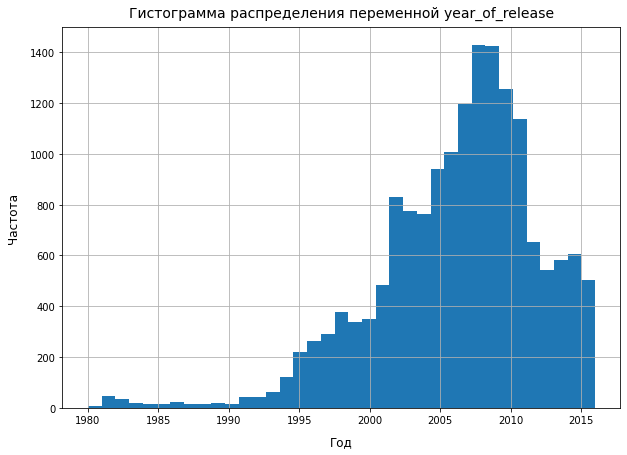

In [45]:
# изучим, сколько игр выпускалось в разные годы, и посмотрим ещё раз 
# на гистограмму переменной

data['year_of_release'].hist(figsize=(10, 7), bins=37)
plt.title('Гистограмма распределения переменной year_of_release',
         fontsize=14, pad=10)
plt.xlabel('Год', fontsize=12, labelpad=10)
plt.ylabel('Частота', fontsize=12, labelpad=10)
print(data['year_of_release'].value_counts().head(10))

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='Red'>🛠 Ошибка в построении гистограммы указана выше.</font>

</font><font color='Blue'><b>Комментарий студента</b></font><br>

Исправила.

Можно отметить, что **наибольшая часть игр была выпущена в период с 2005 по 2011 год, пик выпуска приходится на 2009 год**.

Игры, выпущенные с 1980 по 1990 год, хоть и составляют небольшую часть выборки, могут представлять ценные наблюдения для последующего анализа. Оснований для удаления этих записей нет.

### Изменение продаж по платформам

In [46]:
# изучим, как менялись продажи по платформам

(data
 .pivot_table(
    index='platform',
    values='total_sales',
    columns='year_of_release',
    aggfunc='sum')
 .head(10)
)

year_of_release,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
platform,,,,,,,,,,,,,,,,,,,,,
2600,11.38,35.68,28.88,5.84,0.27,0.45,0.67,1.94,0.74,0.63,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3DO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3DS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,63.20,51.36,56.57,43.76,27.78,15.14
DC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.02,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DS,NaN,NaN,NaN,NaN,NaN,0.02,NaN,NaN,NaN,NaN,...,146.94,145.31,119.54,85.02,26.18,11.01,1.54,NaN,NaN,NaN
GB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.43,64.97,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GBA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GEN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkMagenta'>👉 Наверное, стоило попробовать разобраться с таким артефактом у платформы DS. Тогда бы обнаружили, что это ошибка, так как в 1985 году этой платформы еще не существовало. Визуализация помогает не только определять закономерности, но еще и находить ошибки.</font>
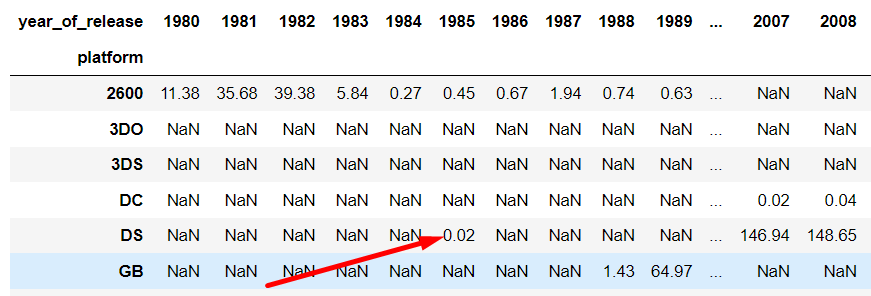

</font><font color='Blue'><b>Комментарий студента</b></font><br>

Лучше заменить это значение на "NaN"? И в таком случае возникает вопрос: платформ много (31), и по каждой есть показатель продаж за 37 лет. Если данных было бы больше, можно ли было заметить подобную ошибку? Выявляются ли подобные ошибки на практике в больших датасетах?

<font color='DarkBlue'><b>Комментарий ревьюера 2</b></font><br>
<font color='DarkMagenta'>👉 Эту ошибку проще удалить. Или попробовать найти год релиза по названию. А такие ошибки хорошо находятся визуализацией, здесь столбчатыми диаграмамми продажи/год релиза по каждой платформе.</font>

</font><font color='Blue'><b>Комментарий студента 2</b></font><br>

Хорошо, спасибо! Удалила выявленную ошибку.

In [47]:
# отобразим год издания игр на каждой платформе

#for p in data['platform'].unique():
 #   plt.subplots()
  #  plt.bar(data['year_of_release'], data['total_sales'])
   # plt.legend([p])

По итогам анализа таблицы видна ошибка: какие-то игры на платформе DS, согласно данным, были выпущены в 1985 году, однако сама игровая консоль была создана только в 2004 году.

Избавимся от данного наблюдения.

In [48]:
data.query('year_of_release == 1985 and platform == "DS"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
15957,Strongest Tokyo University Shogi DS,DS,1985,Action,0.0,0.0,0.02,0.0,NaN,NaN,NonNA,0.02


In [49]:
data = data.drop(index=15957)
data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NonNA,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NonNA,31.38
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NonNA,0.01
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NonNA,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NonNA,0.01
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NonNA,0.01


In [50]:
# выберем платформы с наибольшими суммарными продажами

platform_pivot = data.pivot_table(
    index='platform',
    values='total_sales',
    columns='year_of_release',
    aggfunc='sum'
)

platform_pivot['sum'] = platform_pivot.sum(axis=1)
platform_pivot = platform_pivot.sort_values(by='sum', ascending=False)
platform_pivot.head(10)

year_of_release,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,sum
platform,,,,,,,,,,,,,,,,,,,,,
PS2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,53.90,26.40,5.64,0.45,NaN,NaN,NaN,NaN,NaN,1233.56
X360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,135.26,120.29,170.03,143.84,99.74,88.58,34.74,11.96,1.52,961.24
PS3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,118.52,130.93,142.17,156.78,107.35,113.25,47.76,16.82,3.60,931.33
Wii,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,171.32,206.97,127.95,59.65,21.71,8.59,3.75,1.14,0.18,891.18
DS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,145.31,119.54,85.02,26.18,11.01,1.54,NaN,NaN,NaN,802.76
PS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,727.58
PS4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,25.99,100.00,118.90,69.25,314.14
GBA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,312.88
PSP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,34.55,37.78,35.04,17.82,7.69,3.14,0.24,0.12,NaN,289.53


Первые 6 платформ демонстрируют наибольшие продажи, далее показатели существенно сокращаются. Изучим на графиках, как менялись продажи этих платформ по годам.

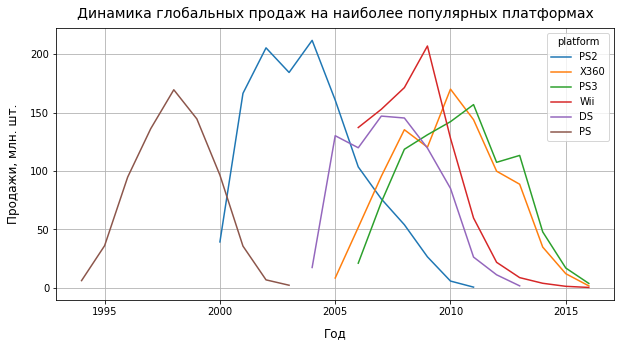

In [51]:
top_platform_sales = platform_pivot.head(6)
top_platform_sales = top_platform_sales.drop('sum', axis=1)
top_platform_sales.T.plot(figsize=(10, 5), grid=True)
plt.title('Динамика глобальных продаж на наиболее популярных платформах',
         fontsize=14, pad=10)
plt.xlabel('Год', fontsize=12, labelpad=10)
plt.ylabel('Продажи, млн. шт.', fontsize=12, labelpad=10)
None

Продажи игр на каждой из топ-6 платформ имеют схожие тренды на графиках: рост, пик и падение. По "пикам" можно определить и характерный срок, за который появляются новые и исчезают старые платформы.

Так, например, судя по графику, продажи игр на платформе **PS** достигли своего пика в 1998 году, следующий пик продаж - игры на платформе **PS2** - был отмечен в 2002 и 2004 годах. Следующий пик - **PS3** - уже в 2011 году. В среднем процесс исчезновения старых платформ и (одновременного) появления новых составляет **5 лет**.

Если оценивать "жизнь" одной платформы от момента старта продаж до полного исчезновения, то она составляет примерно **10 лет**.

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkMagenta'>👉 Как-то не корректно определять срок жизни платформы "на глазок", его расчет из данных таблицы был бы более уместен, например, как показано ниже. Вопрос брать ли платформы всего датасета, или ограничивать периодом начала роста продаж, остается открытым, но можно поэкспериментировать.</font>

</font><font color='Blue'><b>Комментарий студента</b></font><br>

Поняла, спасибо! Рассчитала медианный срок жизни платформы по примеру и скорректировала вывод ниже.

In [52]:
# Комментарий ревьюера
temp = data.copy()
time_life = temp.pivot_table(index='platform', values='year_of_release', aggfunc=['min', 'max']).reset_index()
time_life['life'] = time_life['max'] - time_life['min'] + 1 # в срок жизни платформы, должны входить границы диапазона, 
                                                            # поэтому +1
time_life['life'].median()

7.0

In [53]:
# рассчитаем медианный срок жизни платформы

platform_life_time = data.pivot_table(
    index='platform', values='year_of_release', aggfunc=['min', 'max'])
platform_life_time['life_time'] = platform_life_time['max'] - platform_life_time['min'] + 1
platform_life_time['life_time'].median()

7.0

Как видно из расчётов, **медианный срок жизни всех платформ составляет 7 лет**. Проверим, насколько отличается этот показатель, если рассчитать его на основе 6 крупнейших платформ.

In [54]:
top_platform_sales.index.to_list()

['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']

In [55]:
platform_life_time = platform_life_time.reset_index()
top_platform_life_time = (platform_life_time[platform_life_time['platform']
                        .isin(['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS'])])
top_platform_life_time['life_time'].median()

11.0

Интересно, что срок жизни топ-6 популярных платформ существенно больше - 11.5 лет. Вероятно, чем больше игр приобретается на платформе, тем дольше она "держится" на рынке.

### Изучение актуального периода продаж

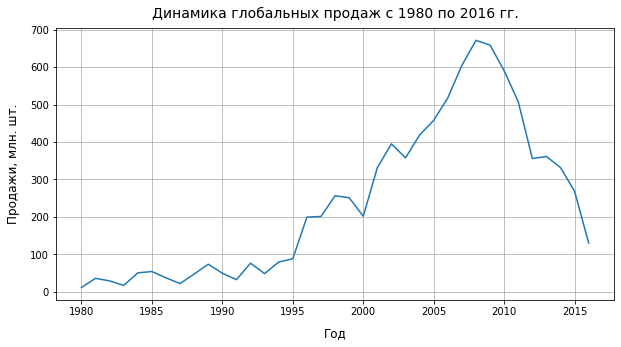

In [56]:
# проанализируем продажи, которые компания получала за предыдущие годы

data.groupby('year_of_release')['total_sales'].sum().plot(figsize=(10, 5))
plt.title('Динамика глобальных продаж с 1980 по 2016 гг.', fontsize=14, pad=10)
plt.xlabel('Год', fontsize=12, labelpad=10)
plt.ylabel('Продажи, млн. шт.', fontsize=12, labelpad=10)
plt.grid()
None

**Наблюдение**: начиная с 2009 года компания демонстрирует резкое сокращение глобальных продаж.

Необходимое условие для определения актуального периода: "данные помогут построить прогноз на 2017 год". Как было определено на предудыщем шаге, средняя "жизнь" платформы составляет 7 лет.

Предположительно, актуальным периодом для анализа, позволяющим корректно построить прогноз продаж на будущий период, будет половина такого срока. С целью дальнейшего анализа избавимся от всех наблюдений до 2013 года, т.е. в выборку войдут все продажи за период с 2013 по 2016 год - в этом периоде будет 3 полных года (2013-2015 гг.).

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='Red'>🛠 Для целей прогнозирования продаж на следующий год даже в традиционных бизнесах редко берут данные более чем за 2-3 года. А в такой динамично меняющейся индустрии, как компьютерные игры и вовсе не стоит брать слишком большой временной интервал - иначе обязательно захватим уже отжившие тренды. Но и очень короткий период не подходит для прогнозирования, так что надо выбирать золотую середину (но не менее 2-х полных лет и не более 5 лет, включая 2016 год).</font>

</font><font color='Blue'><b>Комментарий студента</b></font><br>

Поняла. Решила сократить срок анализа до 3 полных лет, т.е. взяла период с 2013 по 2016 год.

<font color='DarkBlue'><b>Комментарий ревьюера 2</b></font><br>
<font color='DarkGreen'>👌 На практике приходится проводить несколько итераций иследования, изменяя период. Период с которого результат анализа перестает изменяться, принимаем актуальным. Плюс учитываем бизнес-практику отрасли, по которой делаем проект. Аналитику все равно приходится погружаться в бизнес процессы, что бы понимать данные датасета, которые как раз и отражают эти процессы. В нашем случае, 5 лет это примерно половина срока жизни платформы.</font>

</font><font color='Blue'><b>Комментарий студента 2</b></font><br>

Большое спасибо за практический совет!

In [57]:
data = data[data['year_of_release'] > 2012]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2233 entries, 16 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             2233 non-null   object 
 1   platform         2233 non-null   object 
 2   year_of_release  2233 non-null   Int64  
 3   genre            2233 non-null   object 
 4   na_sales         2233 non-null   float64
 5   eu_sales         2233 non-null   float64
 6   jp_sales         2233 non-null   float64
 7   other_sales      2233 non-null   float64
 8   critic_score     991 non-null    float64
 9   user_score       1192 non-null   float64
 10  rating           2233 non-null   object 
 11  total_sales      2233 non-null   float64
dtypes: Int64(1), float64(7), object(4)
memory usage: 229.0+ KB


Получили выборку из **2 233 наблюдений**.

### Глобальные лидеры по продажам среди платформ

In [58]:
# определим, какие платформы с 2013 года лидируют в продажах, а также тренды по продажам

sales_pivot = data.pivot_table(
    index='platform',
    values='total_sales',
    columns='year_of_release',
    aggfunc='sum'
)

sales_pivot['total'] = sales_pivot.sum(axis=1)
sales_pivot = sales_pivot.sort_values(by='total', ascending=False)
sales_pivot

year_of_release,2013,2014,2015,2016,total
platform,,,,,
PS4,25.99,100.00,118.90,69.25,314.14
PS3,113.25,47.76,16.82,3.60,181.43
XOne,18.96,54.07,60.14,26.15,159.32
3DS,56.57,43.76,27.78,15.14,143.25
X360,88.58,34.74,11.96,1.52,136.80
WiiU,21.65,22.03,16.35,4.60,64.63
PC,12.38,13.28,8.52,5.25,39.43
PSV,10.59,11.90,6.25,4.25,32.99
Wii,8.59,3.75,1.14,0.18,13.66


Видим, что в топ-5 среди анализируемых платформ по суммарным продажам с 2013 по 2016 гг. находятся следующие платформы:
1. PS4;
2. PS3;
3. XOne;
4. 3DS;
5. X360.

Проанализируем с помощью графиков, как ведут себя продажи на этих платформах в динамике.

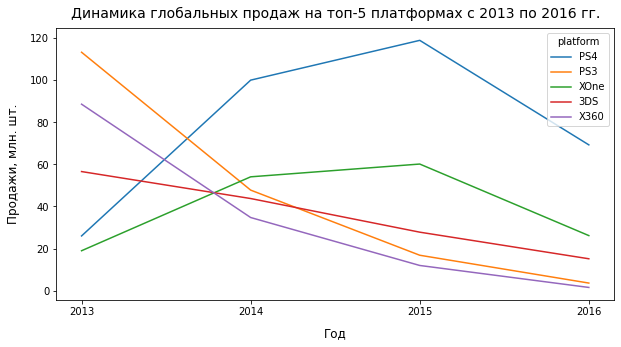

In [59]:
top_sales_pivot = sales_pivot[:5]
top_sales_pivot = top_sales_pivot.drop('total', axis=1)
top_sales_pivot.T.plot(figsize=(10, 5))
plt.title('Динамика глобальных продаж на топ-5 платформах с 2013 по 2016 гг.',
         fontsize=14, pad=10)
plt.xlabel('Год', fontsize=12, labelpad=10)
plt.ylabel('Продажи, млн. шт.', fontsize=12, labelpad=10)
plt.xticks(ticks=[2013, 2014, 2015, 2016])
None

Данные за 2016 год можно не брать во внимание по причине того, что они могут быть неполными. Но даже исключая 2016 год из анализа, можно отметить, что 2 из топ-5 платформ увеличивают свои продажи с 2013 года, в то время как остальные 3 - падают.

Посмотрим на более широкую картину: как ведут себя остальные платформы?

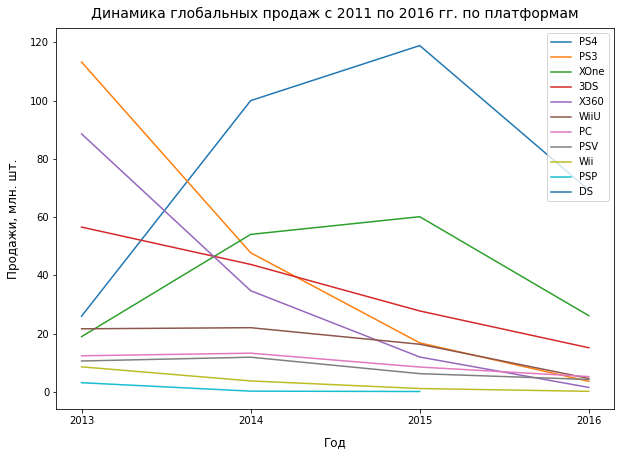

In [60]:
sales_pivot.drop('total', axis=1).T.plot(figsize=(10, 7))
plt.title('Динамика глобальных продаж с 2011 по 2016 гг. по платформам',
         fontsize=14, pad=10)
plt.xlabel('Год', fontsize=12, labelpad=10)
plt.ylabel('Продажи, млн. шт.', fontsize=12, labelpad=10)
plt.xticks(ticks=[2013, 2014, 2015, 2016])
plt.legend(loc='upper right')
None

**Большая часть платформ с 2013 года демонстрирует падение продаж.** Самое заметное - у платформ PS3 и X360, которым на смену пришли PS4 и XOne.

**Платформы PS4 и XOne, таким образом, можно отнести к потенциально прибыльным.**

### Глобальные продажи игр в разбивке по платформам

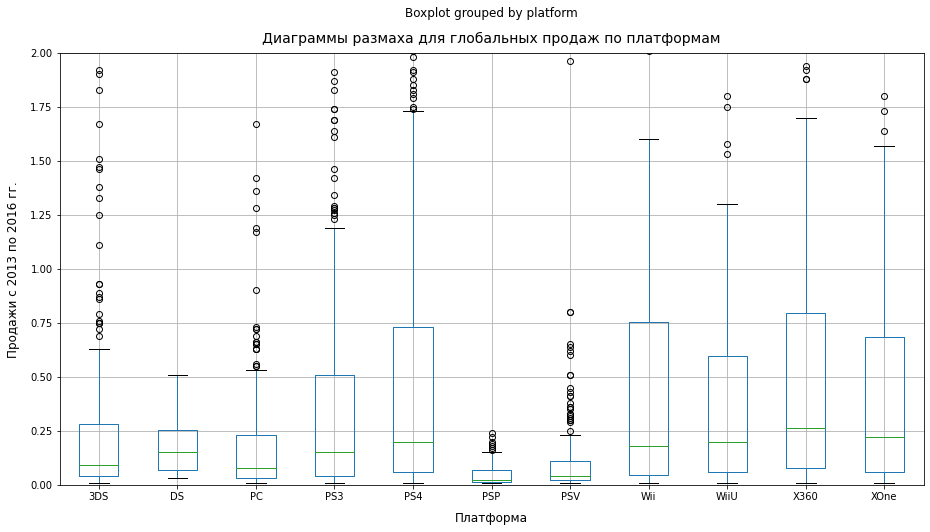

In [61]:
# построим графики "ящик с усами" по глобальным продажам игр в разбивке по платформам

fig, ax = plt.subplots(figsize=(15, 8))
data.boxplot(column=['total_sales'], by='platform', ax=ax)
plt.ylim(0, 2)
plt.title('Диаграммы размаха для глобальных продаж по платформам', fontsize=14, pad=10)
plt.xlabel('Платформа', fontsize=12, labelpad=10)
plt.ylabel('Продажи с 2013 по 2016 гг.', fontsize=12, labelpad=10)
None

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkMagenta'>👉 Здесь уместна <b>вторая</b> диаграмма размаха со всеми максимумами продаж за актуальный период, а не только с масштабированными данными. А так мы не видим выбросы. Примерно вот так:</font>
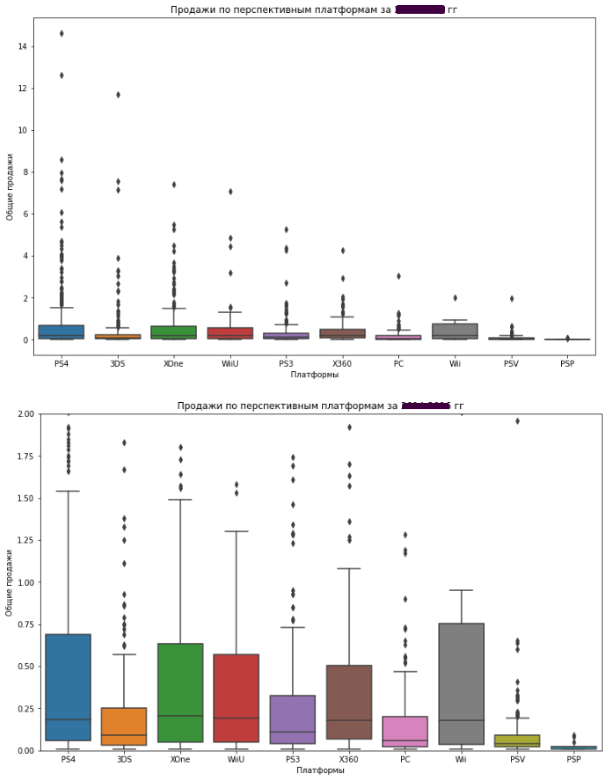

</font><font color='Blue'><b>Комментарий студента</b></font><br>

Принято. Создала аналогичную диаграмму без масштабирования.

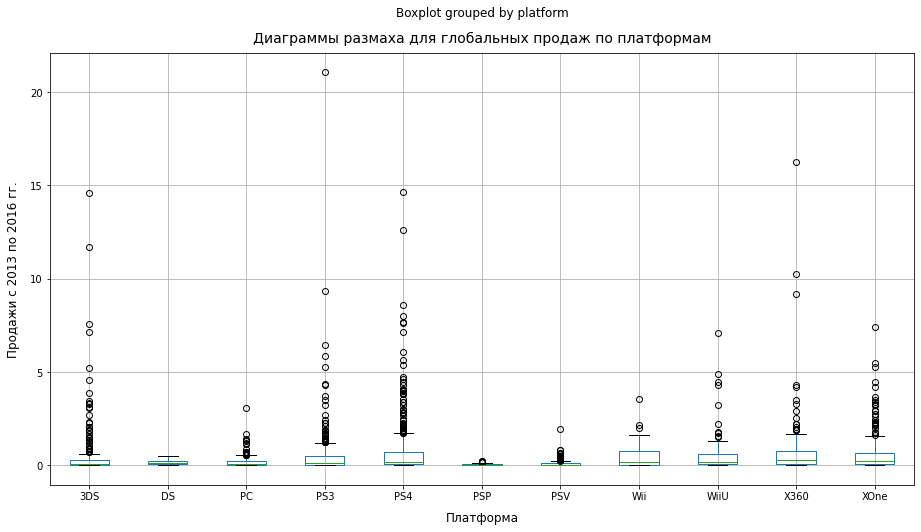

In [62]:
# построим графики "ящик с усами" по глобальным продажам игр в разбивке по платформам
# со всеми выбросами

fig, ax = plt.subplots(figsize=(15,8))
data.boxplot(column=['total_sales'], by='platform', ax=ax)
plt.title('Диаграммы размаха для глобальных продаж по платформам', fontsize=14, pad=10)
plt.xlabel('Платформа', fontsize=12, labelpad=10)
plt.ylabel('Продажи с 2013 по 2016 гг.', fontsize=12, labelpad=10)
None

По графикам видим, что наибольшее медианное значение глобальных продаж с 2013 по 2016 гг. демонстрируют платформы **X360, WiiU, XOne**. Далее следуют платформы **PS3 и PS4**, на всех остальных платформах игры медианное значение продаж ниже.

Интересно также наблюдать за степенью разброса значений продаж внутри платформ. Так, например, платформы X360 и PS4 демонстрируют самый большой разброс: несмотря на высокие медианные значения, продажи разных игр могут быть абсолютно разными. Для сравнения продажи игр на платформах PSP или PS2 имеют гораздо меньший разброс (что связано, скорее всего, с тем, что игры на этих платформах в целом выпускались с 2013 года гораздо реже, поэтому продажи были небольшими и менее вариативными).

Интересно и то, что на самых популярных платформах замечено больше всего выбросов. Вероятно, с 2013 по 2016 год на этих платформах выходили игры, которые завоёвывали огромную популярность у пользователей, что принесло большие продажи.

<font color='DarkBlue'><b>Комментарий ревьюера 2</b></font><br>
<font color='DarkMagenta'>👉 Для интерпретации диаграмм размаха помогает вспомнить, что означают боксплоты. В данном случае расположение боксплота и медианы показывают у какой платформы стабильно высокие продажи. Соответственно, Стримчик должен ориентироваться на такие платформы, так как какая игра в 2017 году выстрелит не известно.</font>
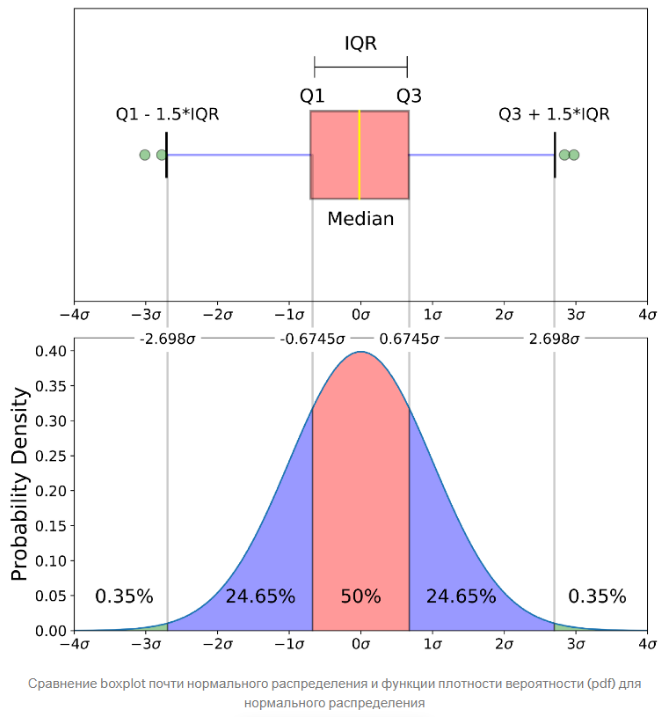

</font><font color='Blue'><b>Комментарий студента 2</b></font><br>

Судя по бокслотам, стабильно более высокие продажи демонстрируют игры на платформах Wii и WiiU (высокие медианные продажи и мало выбросов).

Игры на платформах X360 и PS4 имеют высокие медианные продажи, но менее стабильны (больше выбросов).

### Влияние отзывов пользователей и критиков на продажи

-0.031957110204556376


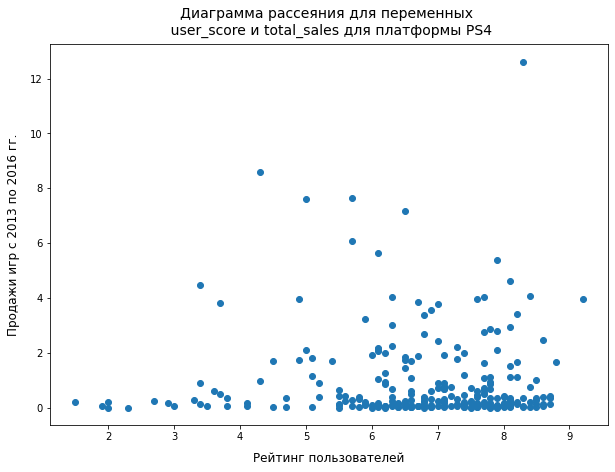

In [63]:
# посмотрим, как влияют отзывы пользователей и критиков 
# на продажи внутри платформы PS4

data_ps4 = data[data['platform'] == 'PS4']

print(data_ps4['user_score'].corr(data_ps4['total_sales']))
plt.figure(figsize=(10, 7))
plt.scatter(data_ps4['user_score'], data_ps4['total_sales'])
plt.title('Диаграмма рассеяния для переменных \n user_score и total_sales для платформы PS4',
         fontsize=14, pad=10)
plt.xlabel('Рейтинг пользователей', fontsize=12, labelpad=10)
plt.ylabel('Продажи игр с 2013 по 2016 гг.', fontsize=12, labelpad=10)
None

Между переменными наблюдается очень слабая взаимосвязь: **рейтинг пользователей практически никак не связан с продажами игр на платформе.**

Проанализируем аналогичную взаимосвязь между рейтингом критиков и продажами.

0.40656790206178095


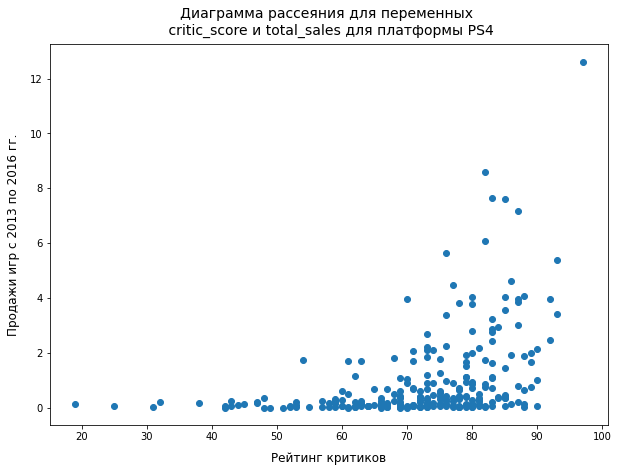

In [64]:
print(data_ps4['critic_score'].corr(data_ps4['total_sales']))

plt.figure(figsize=(10, 7))
plt.scatter(x=data_ps4['critic_score'], y=data_ps4['total_sales'])
plt.title('Диаграмма рассеяния для переменных \n critic_score и total_sales для платформы PS4',
         fontsize=14, pad=10)
plt.xlabel('Рейтинг критиков', fontsize=12, labelpad=10)
plt.ylabel('Продажи игр с 2013 по 2016 гг.', fontsize=12, labelpad=10)
None

Между переменными *critic_score* и *total_sales* на платформе PS4 наблюдается более сильная взаимосвязь (коэффициент корреляции составляет ~ 0.41). Следовательно, **рейтинг критиков имеет взаимосвязь среднего уровня с продажами игр с 2013 по 2016 гг.**

Отметим также, что по мере увеличения оценки критиков происходит резкое увеличение продаж, т.е. **продажи демонстрируют скорее экспоненциальный рост по мере увеличения рейтинга критиков**.

Сопоставим наблюдения с остальными платформами. Будет ли наблюдаться та же тенденция: **рейтинг пользователей практически не связан с продажами игр на платформе, в то время как рейтинг критиков имеет более тесную взаимосвязь с продажами?** Ответить на этот вопрос помогут коэффициенты корреляции между переменными *user_score* и *total_sales*, *critic_score* и *total_sales* по каждой переменной.

In [65]:
# построим матрицу корреляций

corr_matrix = data.groupby('platform')[['critic_score', 'user_score', 'total_sales']].corr()
cm = sns.light_palette("green", as_cmap=True)
corr_matrix = corr_matrix.style.background_gradient(cmap=cm)
corr_matrix

Для 9 из 12 платформ тренд подтверждается: корреляция между рейтингом критиков и продажами более высокая, чем между рейтингом пользователей и продажами. Исключением стали платформы **DS и WiiU**, а также **PS2** по причине того, что данных по критериям недостаточно.

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='Red'>🛠 В задании написано: <b>Соотнесите выводы с продажами игр на других платформах.</b> Предполагается, что мы построим диаграммы рассеяния, а не только посчитаем корреляции и для других платформ. Выводы, сделанные на основе расчетов по нескольким платформам выглядят "весомей" и убедительней. Все платформы не надо, но хотя бы штук пять.  Построение диаграмм рассеяния и расчет корреляции можно сделать циклом по каждой платформе и по каждому виду отзывов.</font>

</font><font color='Blue'><b>Комментарий студента</b></font><br>

Хорошо, ниже попробовала создать такой цикл и сформировала выводы.

In [66]:
# изобразим диаграммы рассеяния для топ-5 платформ по парам переменных:
# user_score и total_sales, critic_score и total_sales

# for p in data['platform'].unique()[:5]:
#    plt.subplots()
#    plt.scatter(x=data['user_score'], y=data['total_sales'])
#    print('Коэффициент корреляции между переменными \n user_score и total_sales для платформы',
#          p, ':', 
#          round(data[data['platform'] == p]['user_score']
#                .corr(data[data['platform'] == p]['total_sales']), 2))
#    plt.scatter(x=data['critic_score'], y=data['total_sales'])
#    print('Коэффициент корреляции между переменными \n critic_score и total_sales для платформы',
#          p, ':', 
#          round(data[data['platform'] == p]['critic_score']
#                .corr(data[data['platform'] == p]['total_sales']), 2))
#    plt.legend([p], loc='upper center')
#    plt.show()

<font color='DarkBlue'><b>Комментарий ревьюера 2</b></font><br>
<font color='Red'>🛠 Каждый вид отзыва должен быть построен на отдельной координатной сетке.</font>
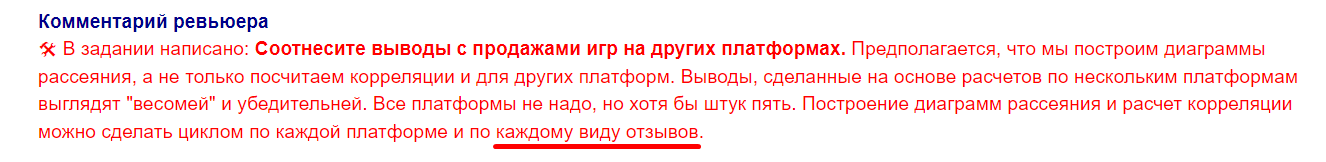

</font><font color='Blue'><b>Комментарий студента 2</b></font><br>

Исправила ниже.

In [67]:
# изобразим диаграммы рассеяния для топ-5 платформ по парам переменных:
# user_score и total_sales, critic_score и total_sales

# for p in data['platform'].unique()[:5]:
#     plt.scatter(x=data['user_score'], y=data['total_sales'], alpha=0.5)
#    plt.legend([p], loc='upper center')
#    plt.title(f'Диаграмма рассеяния между переменными user_score и total_sales \
#\n на платформе {p}')
#    print('Коэффициент корреляции между переменными \n user_score и total_sales \
#для платформы', p, ':', round(data[data['platform'] == p]['user_score']
#                              .corr(data[data['platform'] == p]['total_sales']), 2))
#    plt.show()
    
#for p in data['platform'].unique()[:5]:
#    plt.scatter(x=data['critic_score'], y=data['total_sales'], alpha=0.5)
#    plt.legend([p], loc='upper center')
#    plt.title(f'Диаграмма рассеяния между переменными critic_score и total_sales \
#\n на платформе {p}')
#    print('Коэффициент корреляции между переменными \n critic_score и total_sales \
#для платформы', p, ':', round(data[data['platform'] == p]['critic_score']
#                              .corr(data[data['platform'] == p]['total_sales']), 2))
#    plt.show()

<font color='DarkBlue'><b>Комментарий ревьюера 3</b></font><br>
<font color='Red'>🛠 Для чего делается визуализация? Ответ, для ревьюера - не принимается. Делается для анализа. Как можно анализировать одинаковые диаграммы?</font>
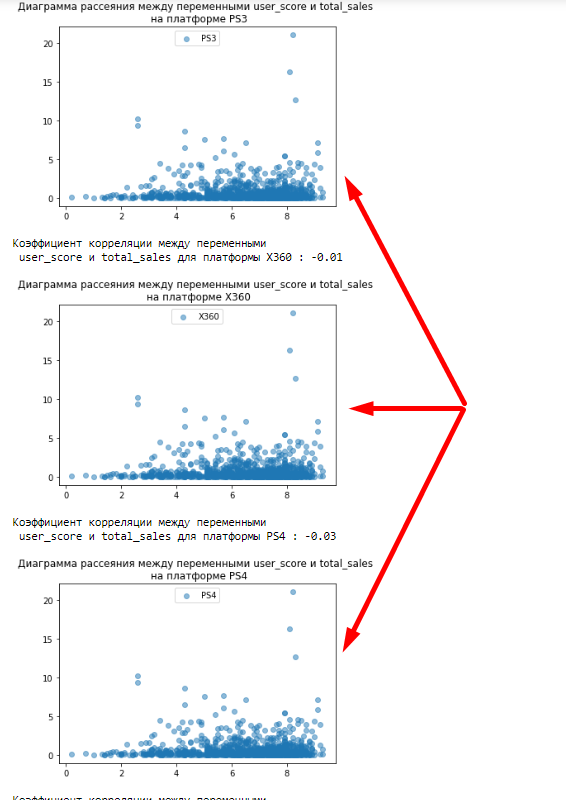

</font><font color='Blue'><b>Комментарий студента 3</b></font><br>

Вероятно, одинаковые диаграммы лучше отобразить на одном графике. Сделала ниже.

<font color='DarkBlue'><b>Комментарий ревьюера 4</b></font><br>
<font color='DarkMagenta'>👉 Они одинаковые потому, что была ошибка в коде.</font>

In [68]:
# изобразим диаграммы рассеяния для топ-5 платформ по парам переменных:
# user_score и total_sales, critic_score и total_sales

#print('Коэффициенты корреляции между переменными \n user_score и total_sales \
#для платформ:')
#for p in data['platform'].unique()[:5]:
#    print(p, ':', round(data[data['platform'] == p]['user_score']
#                        .corr(data[data['platform'] == p]['total_sales']), 2))

#fig, ax = plt.subplots(figsize=(10, 7))
#for p in data['platform'].unique()[:5]:
#    sns.scatterplot(data[data['platform'] == p]['user_score'], 
#                    data[data['platform'] == p]['total_sales'], label=p)
#    ax.legend(loc='upper left')
#    ax.set_title(f'Диаграмма рассеяния между переменными user_score и total_sales \
#\n на разных платформах')
#plt.xlabel('Рейтинг пользователей')
#plt.ylabel('Продажи, млн. шт.')
#plt.show()


#print('Коэффициенты корреляции между переменными \n critic_score и total_sales \
#для платформ:')
#for p in data['platform'].unique()[:5]:
#    print(p, ':', round(data[data['platform'] == p]['critic_score']
#                        .corr(data[data['platform'] == p]['total_sales']), 2))

#fig, ax = plt.subplots(figsize=(10, 7))
#for p in data['platform'].unique()[:5]:
#    sns.scatterplot(data[data['platform'] == p]['critic_score'], 
#                    data[data['platform'] == p]['total_sales'], label=p)
#    ax.legend(loc='upper left')
#    ax.set_title(f'Диаграмма рассеяния между переменными critic_score и total_sales \
#\n на разных платформах')
#plt.xlabel('Рейтинг критиков')
#plt.ylabel('Продажи, млн. шт.')
#plt.show()

<font color='DarkBlue'><b>Комментарий ревьюера 4</b></font><br>
<font color='Red'>🛠 В данном калейдоскопе ни чего не видно. Необходимо построить диаграммы рассеяния не менее, чем по пяти платформам на отдельных диаграммах, и по отзывам критиков, и по отзывам пользователей.<br>Почему не читаем замечаний ревьюера? Количество проверок проекта ограничено, мы уже четвертый раз не можем правильно выполнить этот раздел.</font>
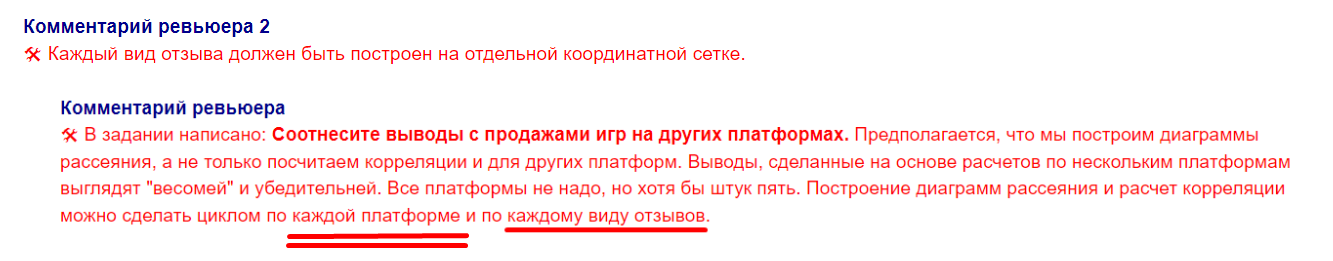

</font><font color='Blue'><b>Комментарий студента 4</b></font><br>

Не так интерпретировала комментарий. Исправила ниже.

Коэффициенты корреляции для платформы PS3 : 
 user_score и total_sales: 0.0 
 critic_score и total_sales: 0.33


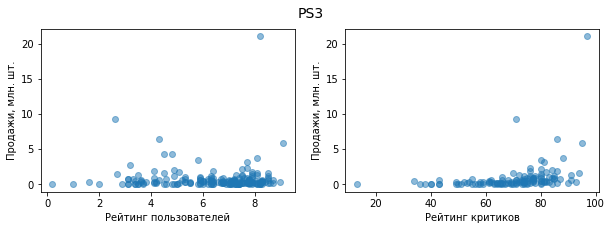

Коэффициенты корреляции для платформы X360 : 
 user_score и total_sales: -0.01 
 critic_score и total_sales: 0.35


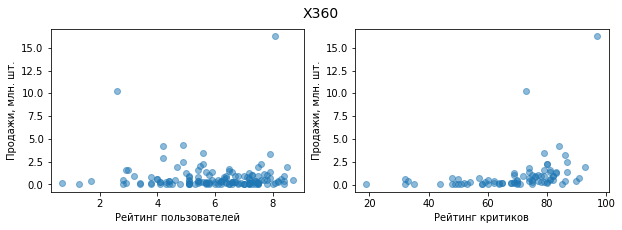

Коэффициенты корреляции для платформы PS4 : 
 user_score и total_sales: -0.03 
 critic_score и total_sales: 0.41


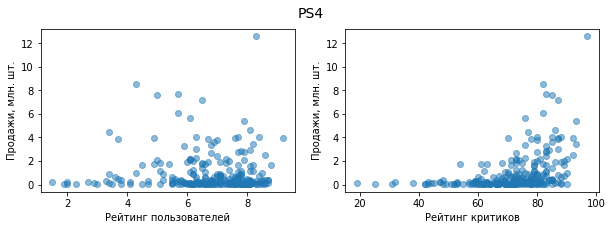

Коэффициенты корреляции для платформы 3DS : 
 user_score и total_sales: 0.24 
 critic_score и total_sales: 0.36


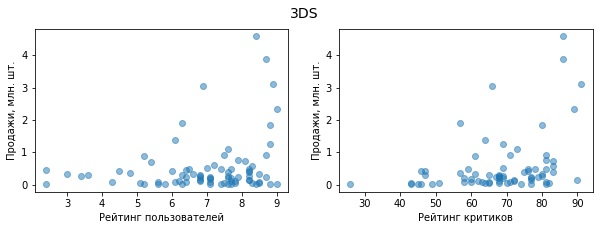

Коэффициенты корреляции для платформы XOne : 
 user_score и total_sales: -0.07 
 critic_score и total_sales: 0.42


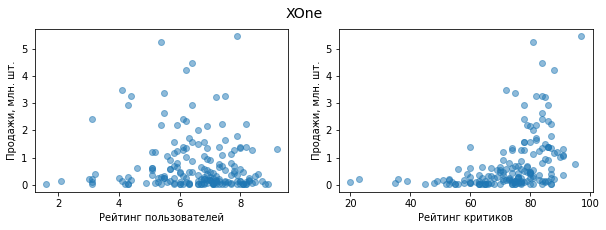

In [69]:
# изобразим диаграммы рассеяния для топ-5 платформ по парам переменных:
# user_score и total_sales, critic_score и total_sales

for p in data['platform'].unique()[:5]:
    data_platform = data[data['platform'] == p]
    print('Коэффициенты корреляции для платформы', p, ': \n user_score и total_sales:',
          round(data_platform['user_score'].corr(data_platform['total_sales']), 2),
         '\n critic_score и total_sales:',
          round(data_platform['critic_score'].corr(data_platform['total_sales']), 2))
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    fig.suptitle(p, fontsize=14)
    ax[0].scatter(data_platform['user_score'], data_platform['total_sales'], alpha=0.5)
    ax[1].scatter(data_platform['critic_score'], data_platform['total_sales'], alpha=0.5)
    ax[0].set(xlabel='Рейтинг пользователей')
    ax[1].set(xlabel='Рейтинг критиков')
    ax[0].set(ylabel='Продажи, млн. шт.')
    ax[1].set(ylabel='Продажи, млн. шт.')
    plt.show()

На большинстве из топ-5 платформ подтверждается выявленный тренд: **оценки пользователей практически не связаны с продажами игр, в то время как оценка критиков и продажи связаны положительной взаимосвязью среднего уровня**. Исключением можно назвать платформу 3DS: на ней оценки пользователей также обладают слабой положительной взаимосвязью с продажами игр.

<font color='DarkBlue'><b>Комментарий ревьюера 5</b></font><br>
<font color='DarkGreen'>👌 Для оценки корреляции лучше пользоваться вот этой шкалой:</font>
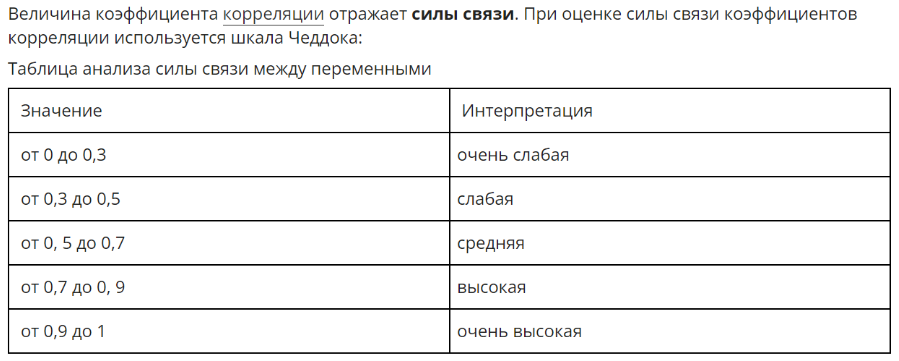

### Распределение игр по жанрам

In [70]:
genre_pivot = (data
               .pivot_table(
                   index='genre',
                   values='total_sales',
                   aggfunc=['sum', 'median'])
)
genre_pivot.columns=['sum', 'median']
genre_pivot = genre_pivot.sort_values(by='sum', ascending=False)
genre_pivot

,sum,median
genre,,
Action,321.87,0.110
Shooter,232.98,0.450
Sports,150.65,0.240
Role-Playing,145.89,0.125
Misc,62.82,0.100
Platform,42.63,0.225
Racing,39.89,0.120
Fighting,35.31,0.125
Adventure,23.64,0.030


In [71]:
genre_pivot = genre_pivot.sort_values(by='median', ascending=False)
genre_pivot

,sum,median
genre,,
Shooter,232.98,0.450
Sports,150.65,0.240
Platform,42.63,0.225
Role-Playing,145.89,0.125
Fighting,35.31,0.125
Racing,39.89,0.120
Action,321.87,0.110
Simulation,21.76,0.100
Misc,62.82,0.100


Наибольшие суммарные продажи с 2013 по 2016 гг. демонстрировали игры жанров **Action** и **Shooter**, наименее популярны игры жанров **Strategy** и **Puzzle**.

Однако при сравнении медианных продаж картина меняется: лидерство удерживают игры жанра **Shooter**, а вот **Action** - существенно ниже в рейтинге.

Для более детального изучения данных посмотрим на диаграммы размаха глобальных продаж по жанрам.

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkMagenta'>👉 Здесь попали в ловушку, что максимальные продажи являются самыми прибыльными. Но в данных продажи по жанру для разных платформ, и если одна платформа со своей одной игрой в данном жанре выстрелила, а остальные провалились, то все равно будет виден максимум общих продаж. Но для прибыльности нужны стабильные жанры, который приносят доход не зависимо от платформы, значит на этот жанр есть устойчивый спрос.</font><br>
<font color='Red'>🛠 Поэтому лучше добавить сравнение медианных продаж, проиллюстрировав их диаграммами размаха и изменить промежуточные выводы.</font>

</font><font color='Blue'><b>Комментарий студента</b></font><br>

Поняла. Добавила в сводную таблицу медианные продажи. Ниже добавила диаграммы размаха.

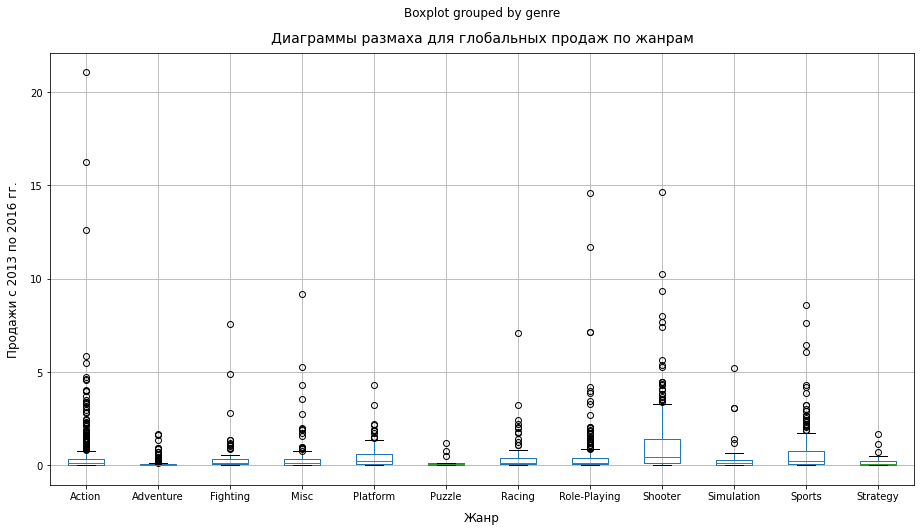

In [72]:
fig, ax = plt.subplots(figsize=(15,8))
data.boxplot(column=['total_sales'], by='genre', ax=ax)
plt.title('Диаграммы размаха для глобальных продаж по жанрам', fontsize=14, pad=10)
plt.xlabel('Жанр', fontsize=12, labelpad=10)
plt.ylabel('Продажи с 2013 по 2016 гг.', fontsize=12, labelpad=10)
None

На диаграммах размаха видно: суммарные продажи игр жанра Action больше всех остальных из-за наличия большого количества выбросов - в частности, за последние 3 года было 3 игры с продажами более 10 млн. копий, а одна игра - более 20 млн. копий.

In [73]:
# посмотрим, какая игра жанра Action набрала наибольшее кол-во продаж за последние 3 года

data[data['genre'] == 'Action'].max()

name               inFAMOUS: Second Son
platform                           XOne
year_of_release                    2016
genre                            Action
na_sales                           9.66
eu_sales                           9.09
jp_sales                           2.79
other_sales                        3.96
critic_score                       97.0
user_score                          9.1
rating                                T
total_sales                       21.05
dtype: object

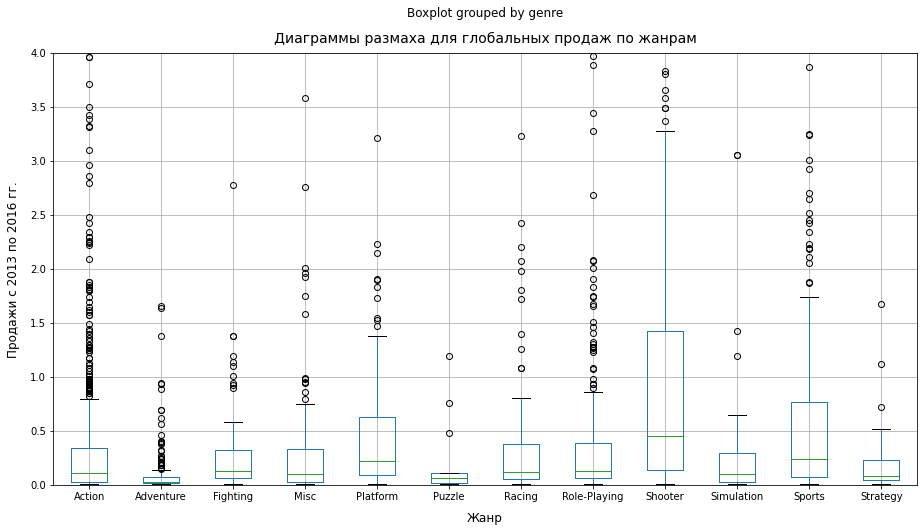

In [74]:
# увеличим масштаб диаграмм размаха, чтобы лучше увидеть разброс значений
# по продажам игр в разбивке по жанрам

fig, ax = plt.subplots(figsize=(15, 8))
data.boxplot(column=['total_sales'], by='genre', ax=ax)
plt.ylim(0, 4)
plt.title('Диаграммы размаха для глобальных продаж по жанрам', fontsize=14, pad=10)
plt.xlabel('Жанр', fontsize=12, labelpad=10)
plt.ylabel('Продажи с 2013 по 2016 гг.', fontsize=12, labelpad=10)
None

На основе графиков можно сделать вывод: **более устойчиво выглядят продажи игр жанров Shooter, Sports и Platform**. Проверим, соблюдается ли аналогичный тренд при анализе продаж в динамике.

<font color='DarkBlue'><b>Комментарий ревьюера 2</b></font><br>
<font color='DarkGreen'>👌 В проекте под "прибыльностью" понимается наличие устойчивого спроса пользователей на данный жанр. Можно сделать уникальный сюжет, быстрый движок, красивую графику и вложить немеряно денег в рекламу и продажи игры подпрыгнут. Но нам лучше выбирать игру из жанра, на которой есть постоянный спрос независимо от маркетинговых усилий производителей игр.<br>
Это хороший пример, когда на одних и тех же данных разные диаграммы дают разный анализ. Визуализация это не только красивое представление табличных данных, а еще и инструмент анализа.</font>

</font><font color='Blue'><b>Комментарий студента 2</b></font><br>

Да, как раз построенные боксплоты помогли увидеть, по каким жанрам наблюдаются наибольшие выбросы.

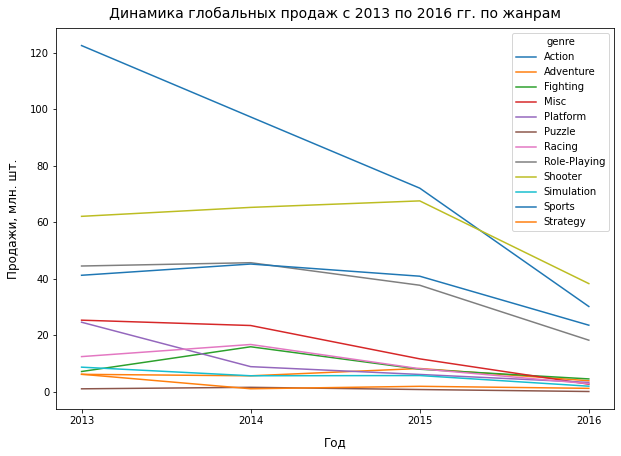

In [75]:
# посмотрим, как вели себя глобальные продажи игр по жанрам за последние 3 года

genre_pivot = (data
               .pivot_table(
                   index='genre',
                   values='total_sales',
                   columns='year_of_release',
                   aggfunc='sum')
)

genre_pivot.T.plot(figsize=(10, 7))
plt.title('Динамика глобальных продаж с 2013 по 2016 гг. по жанрам',
         fontsize=14, pad=10)
plt.xlabel('Год', fontsize=12, labelpad=10)
plt.ylabel('Продажи, млн. шт.', fontsize=12, labelpad=10)
plt.xticks([2013, 2014, 2015, 2016])
None

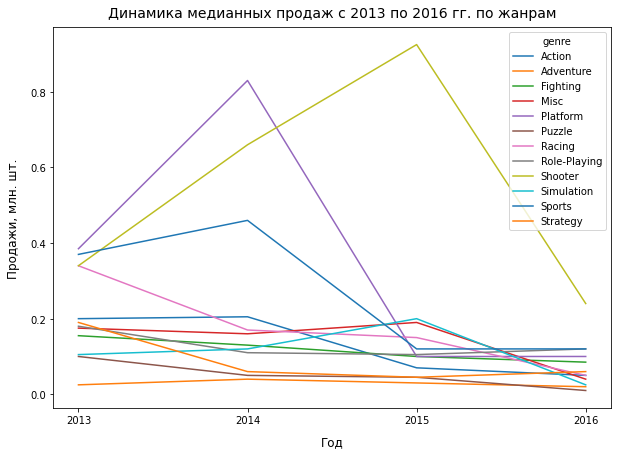

In [76]:
# проверим аналогичную динамику медианных продаж

genre_pivot_median = (data.pivot_table(
    index='genre',values='total_sales', columns='year_of_release', aggfunc='median')
)

genre_pivot_median.T.plot(figsize=(10, 7))
plt.title('Динамика медианных продаж с 2013 по 2016 гг. по жанрам',
         fontsize=14, pad=10)
plt.xlabel('Год', fontsize=12, labelpad=10)
plt.ylabel('Продажи, млн. шт.', fontsize=12, labelpad=10)
plt.xticks([2013, 2014, 2015, 2016])
None

Несмотря на своё лидерство, **с 2013 года игры жанра Action теряют свои позиции на глобальном рынке**.

**Продажи игр жанра Shooter выглядят более стабильно** как с позиции медианных продаж с 2013 по 2016 гг., так и с точки зрения суммарных продаж игр за аналогичный период. Жанры Sports и Platform также выглядят привлекательно с точки зрения медианных продаж, однако мы не можем быть уверены в их стабильности.

### Выводы по итогам исследовательского анализа

**Ключевые выводы по итогам исследовательского анализа:**
1. **пик продаж компьютерных игр интернет-магазина пришёлся на период с 2005 по 2011 года, максимум - в 2009 году. Начиная с этого же года глобальные продажи компании стремительно снижаются**;
2. в "топе" глобальных продаж за последние 3 года (2013-2016 гг.) находятся платформы **PS4, PS3, XOne, 3DS и X360**;
3. **уверенный рост на глобальном рынке за последние 3 года демонстрируют 2 платформы: PS4 и XOne**. Первые игры на них продавались в 2013 году, и на протяжении двух лет темпы роста продаж игр на PS4 и XOne позволили перегнать "старые" платформы;
4. практически на всех платформах не наблюдается взаимосвязи между оценкой пользователей и продажами игр на платформе. **Более сильно на продажи влияют оценки критиков, при этом рост продаж имеет скорее экспоненциальный характер (по мере роста оценок критиков сила связи с продажами также увеличивается)**;
5. **наибольшие суммарные продажи за последние 3 года принесли игры жанра Action, однако с 2013 года они теряют свои позиции на глобальном рынке**. Более стабильно выглядят игры жанра **Shooter**;
6. **средний срок "жизни" игровой платформы составляет 7 лет**, при этом для топ-6 платформ этот показатель существенно выше - 11.5 лет.

## Портреты пользователей

Составим портрет пользователя для каждого из представленных регионов (NA, EU, JP). Определим:
1. топ-5 игровых платформ;
2. топ-5 жанров;
3. влияние рейтинга ESRB на продажи.

### NA

#### Топ-5 платформ в Северной Америке

In [77]:
# создадим отдельный датафрейм для игр, проданных в Северной Америке

data_na = data.drop(['eu_sales', 'jp_sales', 'other_sales'], axis=1)
data_na.head()

,name,platform,year_of_release,genre,na_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,NaN,NaN,NonNA,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,NaN,NaN,NonNA,14.60
42,Grand Theft Auto V,PS4,2014,Action,3.96,97.0,8.3,M,12.62


In [78]:
data_na_platform_pivot = (data_na
 .pivot_table(index='platform', values='na_sales', aggfunc='sum')
 .sort_values(by='na_sales', ascending=False)
)

data_na_platform_pivot['sales_share'] = (round(data_na_platform_pivot['na_sales'] / 
                                         data_na_platform_pivot['na_sales'].sum() * 100, 1))
data_na_platform_pivot.head()

,na_sales,sales_share
platform,,
PS4,108.74,24.8
XOne,93.12,21.3
X360,81.66,18.7
PS3,63.50,14.5
3DS,38.20,8.7


Наибольшую долю продаж в Северной Америке с 2013 по 2016 гг. составляли игры на платформе **PS4 (24.8% от всех продаж в регионе)**. В пятёрку наиболее популярных платформ в регионе также входят платформы **XOne (21.3%), X360 (18.7%), PS3 (14.5%) и 3DS (8.7%)**.

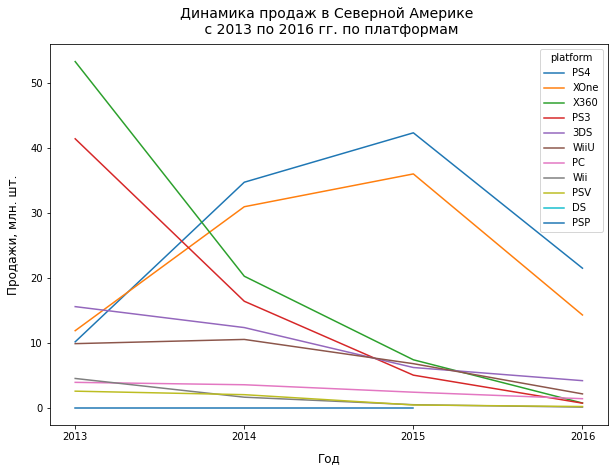

In [79]:
# дополнительно проверим, как ведут себя продажи игр 
# на платформах в Северной Америке в динамике

na_platform_pivot = data_na.pivot_table(
    index='platform',
    values='na_sales',
    columns='year_of_release',
    aggfunc='sum'
)

na_platform_pivot['total'] = na_platform_pivot.sum(axis=1)
na_platform_pivot = na_platform_pivot.sort_values(by='total', ascending=False)
na_platform_pivot = na_platform_pivot.drop('total', axis=1)
na_platform_pivot.T.plot(figsize=(10, 7))
plt.title('Динамика продаж в Северной Америке \n с 2013 по 2016 гг. по платформам',
         fontsize=14, pad=10)
plt.xlabel('Год', fontsize=12, labelpad=10)
plt.ylabel('Продажи, млн. шт.', fontsize=12, labelpad=10)
plt.xticks([2013, 2014, 2015, 2016])
None

Видим следующее: **помимо лидерства в суммарных продажах за 2013-2016 гг., платформы PS4 и XOne демонстрируют рост продаж и в динамике**.

**Продажи игр на платформах X360 и PS3 на рынке Северной Америки с 2013 года постоянно снижаются**.

#### Топ-5 жанров в Северной Америке

In [80]:
data_na_genre_pivot = (data_na
 .pivot_table(index='genre', values='na_sales', aggfunc='sum')
 .sort_values(by='na_sales', ascending=False)
)

data_na_genre_pivot['sales_share'] = (round(data_na_genre_pivot['na_sales'] / 
                                         data_na_genre_pivot['na_sales'].sum() * 100, 1))
data_na_genre_pivot.head()

,na_sales,sales_share
genre,,
Action,126.05,28.8
Shooter,109.74,25.1
Sports,65.27,14.9
Role-Playing,46.40,10.6
Misc,27.49,6.3


Больше всего в Северной Америке с 2013 по 2016 гг. популярностью пользовались игры жанра **Action (28.8% всех продаж в Северной Америке в соответствующий период)**.

В пятёрку наиболее популярных жанров также вошли: **Shooter (25.1%), Sports (14.9%), Role-Playing (10.6%) и Misc (6.3%)**.

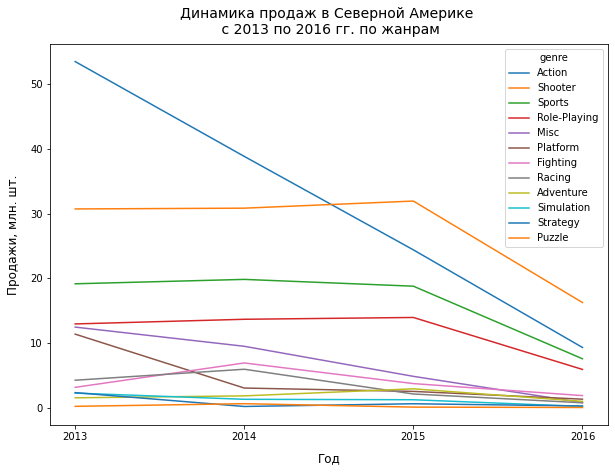

In [81]:
# дополнительно проверим, как ведут себя продажи игр 
# разных жанров в Северной Америке в динамике

na_genre_pivot = data_na.pivot_table(
    index='genre',
    values='na_sales',
    columns='year_of_release',
    aggfunc='sum'
)

na_genre_pivot['total'] = na_genre_pivot.sum(axis=1)
na_genre_pivot = na_genre_pivot.sort_values(by='total', ascending=False)
na_genre_pivot = na_genre_pivot.drop('total', axis=1)
na_genre_pivot.T.plot(figsize=(10, 7))
plt.title('Динамика продаж в Северной Америке \n с 2013 по 2016 гг. по жанрам',
         fontsize=14, pad=10)
plt.xlabel('Год', fontsize=12, labelpad=10)
plt.ylabel('Продажи, млн. шт.', fontsize=12, labelpad=10)
plt.xticks([2013, 2014, 2015, 2016])
None

Общая тенденция продаж по жанрам в Северной Америке с 2013 по 2016 гг. соответствует глобальному тренду: **игры жанра Action теряют позиции, в то время как игры жанров Shooter, Sports и Role-Playing постепенно приходят им на замену**.

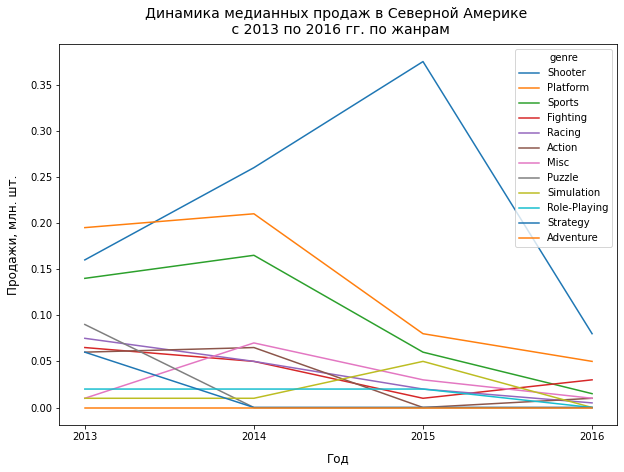

In [82]:
# дополнительно проверим, как ведут себя медианные продажи игр 
# разных жанров в Северной Америке в динамике

na_genre_pivot_median = data_na.pivot_table(
    index='genre',
    values='na_sales',
    columns='year_of_release',
    aggfunc='median'
)

na_genre_pivot_median['total'] = na_genre_pivot_median.sum(axis=1)
na_genre_pivot_median = na_genre_pivot_median.sort_values(by='total', ascending=False)
na_genre_pivot_median = na_genre_pivot_median.drop('total', axis=1)
na_genre_pivot_median.T.plot(figsize=(10, 7))
plt.title('Динамика медианных продаж в Северной Америке \n с 2013 по 2016 гг. по жанрам',
         fontsize=14, pad=10)
plt.xlabel('Год', fontsize=12, labelpad=10)
plt.ylabel('Продажи, млн. шт.', fontsize=12, labelpad=10)
plt.xticks([2013, 2014, 2015, 2016])
None

Продажи игр в Северной Америке по жанрам подтверждают общий тренд: более устойчиво выглядят игры жанра **Shooter**.

#### Влияние рейтинга ESRB на продажи игр в Северной Америке

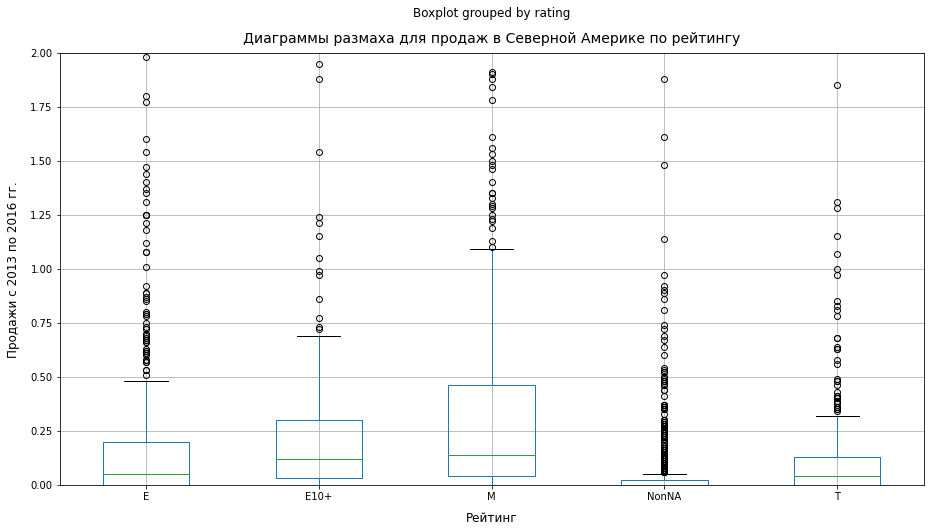

In [83]:
# построим диаграммы размаха переменной продаж в Северной Америке для каждого рейтинга

fig, ax = plt.subplots(figsize=(15, 8))
data_na.boxplot(column=['na_sales'], by='rating', ax=ax)
plt.ylim(0, 2)
plt.title('Диаграммы размаха для продаж в Северной Америке по рейтингу', fontsize=14, pad=10)
plt.xlabel('Рейтинг', fontsize=12, labelpad=10)
plt.ylabel('Продажи с 2013 по 2016 гг.', fontsize=12, labelpad=10)
None

**Наибольшим спросом в Северной Америке с 2013 по 2016 гг. пользовались игры с рейтингом M (17+).** Посмотрим, сколько всего игр было продано в Северной Америке в разбивке по рейтингу.

In [84]:
na_sales_by_rating = (data_na
 .pivot_table(index='rating', values='na_sales', aggfunc='sum')
 .sort_values(by='na_sales', ascending=False)
)

na_sales_by_rating['na_sales_share'] = (round(na_sales_by_rating['na_sales'] / 
                                     na_sales_by_rating['na_sales'].sum() * 100, 1))
na_sales_by_rating

,na_sales,na_sales_share
rating,,
M,165.21,37.7
NonNA,89.42,20.4
E,79.05,18.1
E10+,54.24,12.4
T,49.79,11.4


**Доля игр рейтинга M (17+), проданных в Северной Америке с 2013 по 2016 гг., составляет 37.7%. В перечень наиболее популярных игр также вошли игры рейтинга E (0+; 18.1% продаж), E10+ (10+; 12.4%) и T (13+; 11.4%).**

20.4% продаж за актуальный период составляют игры, изданные не в США или Канаде (NonNA) и, как следствие, не получившие рейтинг ESRB.

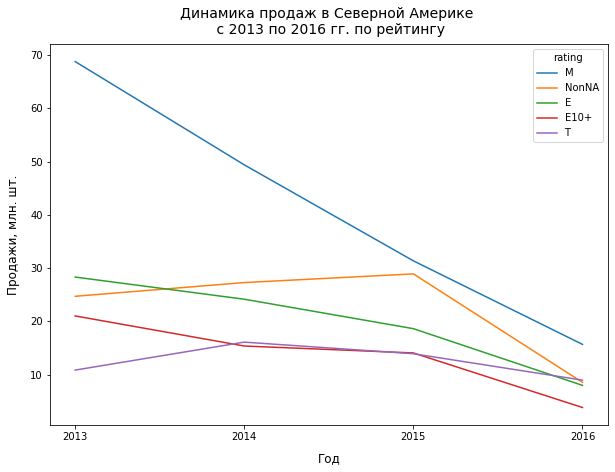

In [85]:
# дополнительно проверим, как ведут себя продажи игр 
# разного рейтинга в Северной Америке в динамике

na_rating_pivot = data_na.pivot_table(
    index='rating',
    values='na_sales',
    columns='year_of_release',
    aggfunc='sum'
)

na_rating_pivot['total'] = na_rating_pivot.sum(axis=1)
na_rating_pivot = na_rating_pivot.sort_values(by='total', ascending=False)
na_rating_pivot = na_rating_pivot.drop('total', axis=1)
na_rating_pivot.T.plot(figsize=(10, 7))
plt.title('Динамика продаж в Северной Америке \n с 2013 по 2016 гг. по рейтингу',
         fontsize=14, pad=10)
plt.xlabel('Год', fontsize=12, labelpad=10)
plt.ylabel('Продажи, млн. шт.', fontsize=12, labelpad=10)
plt.xticks([2013, 2014, 2015, 2016])
None

In [86]:
data_na['rating'].unique()

array(['M', 'NonNA', 'E', 'T', 'E10+'], dtype=object)

В разбивке по рейтингам заметно **существенное падение продаж игр рейтинга M (17+)**.

Интересное наблюдение: **с 2013 года в Северной Америке наблюдается небольшой рост продаж игр, произведённых не в США и не в Канаде** - это можно понять по увеличению продаж игр с установленной заглушкой NonNA.

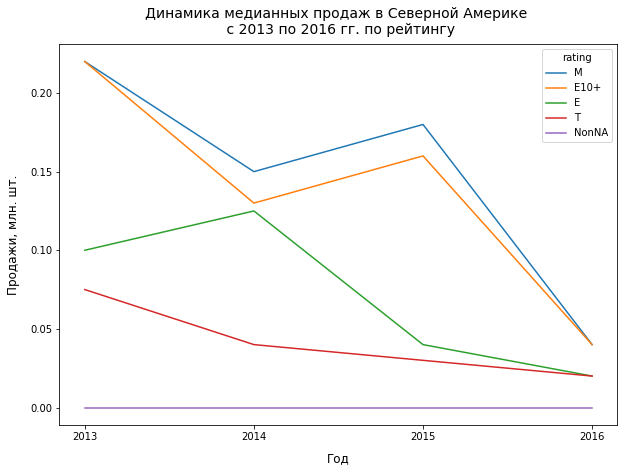

In [87]:
# дополнительно проверим, как ведут себя медианные продажи игр 
# разного рейтинга в Северной Америке в динамике

na_rating_pivot_median = data_na.pivot_table(
    index='rating',
    values='na_sales',
    columns='year_of_release',
    aggfunc='median'
)

na_rating_pivot_median['total'] = na_rating_pivot_median.sum(axis=1)
na_rating_pivot_median = na_rating_pivot_median.sort_values(by='total', ascending=False)
na_rating_pivot_median = na_rating_pivot_median.drop('total', axis=1)
na_rating_pivot_median.T.plot(figsize=(10, 7))
plt.title('Динамика медианных продаж в Северной Америке \n с 2013 по 2016 гг. по рейтингу',
         fontsize=14, pad=10)
plt.xlabel('Год', fontsize=12, labelpad=10)
plt.ylabel('Продажи, млн. шт.', fontsize=12, labelpad=10)
plt.xticks([2013, 2014, 2015, 2016])
None

Несмотря на падение суммарных продаж, **игры жанра M выглядят более устойчиво с точки зрения медианных продаж**.

Медианные продажи игр не из США или Америки находятся на последнем месте. Учитывая рост суммарных продаж таких игр, можно сделать вывод, что **с 2013 года в Северную Америку "зашло" гораздо больше игр из других стран, однако их продажи нельзя считать успешными**. Рост продаж происходит из-за увеличения количества самих игр, а не продаж каждой отдельной игры.

#### Портрет пользователя из Северной Америки

Исходя из анализа, можем сформировать черты, которые характеризуют **портрет среднестатистического пользователя компьютерных игр в Северной Америке**:
1. приобретает игры для платформ PS4 или XOne;
2. жанр игры - Shooter;
3. рейтинг игры - M (17+).

### EU

#### Топ-5 платформ в Европе

In [88]:
# создадим отдельный датафрейм для игр, проданных в Европе

data_eu = data.drop(['na_sales', 'jp_sales', 'other_sales'], axis=1)
data_eu.head()

,name,platform,year_of_release,genre,eu_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,9.09,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,5.14,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,5.86,NaN,NaN,NonNA,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,4.19,NaN,NaN,NonNA,14.60
42,Grand Theft Auto V,PS4,2014,Action,6.31,97.0,8.3,M,12.62


In [89]:
data_eu_platform_pivot = (data_eu
 .pivot_table(index='platform', values='eu_sales', aggfunc='sum')
 .sort_values(by='eu_sales', ascending=False)
)

data_eu_platform_pivot['sales_share'] = (round(data_eu_platform_pivot['eu_sales'] / 
                                         data_eu_platform_pivot['eu_sales'].sum() * 100, 1))
data_eu_platform_pivot.head()

,eu_sales,sales_share
platform,,
PS4,141.09,36.0
PS3,67.81,17.3
XOne,51.59,13.2
X360,42.52,10.8
3DS,30.96,7.9


Наибольшую долю продаж в Европе с 2013 по 2016 гг. составляли игры на платформе **PS4 (36.0% от всех продаж в регионе)**. В пятёрку наиболее популярных платформ в регионе также входят платформы **PS3 (17.3%), XOne (13.2%), X360 (10.8%) и 3DS (7.9%)**.

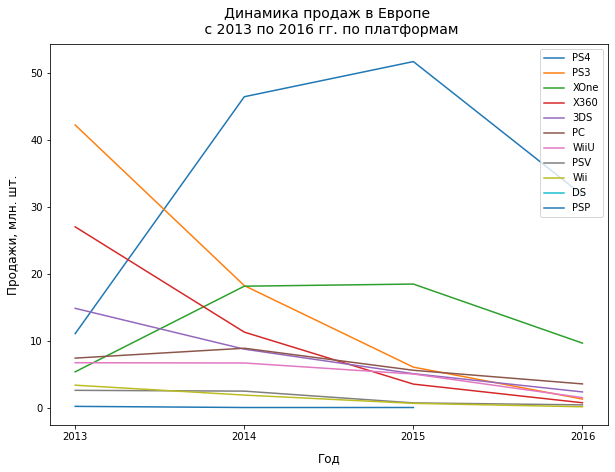

In [90]:
# дополнительно проверим, как ведут себя продажи игр 
# на платформах в Европе в динамике

eu_platform_pivot = data_eu.pivot_table(
    index='platform',
    values='eu_sales',
    columns='year_of_release',
    aggfunc='sum'
)

eu_platform_pivot['total'] = eu_platform_pivot.sum(axis=1)
eu_platform_pivot = eu_platform_pivot.sort_values(by='total', ascending=False)
eu_platform_pivot = eu_platform_pivot.drop('total', axis=1)
eu_platform_pivot.T.plot(figsize=(10, 7))
plt.title('Динамика продаж в Европе \n с 2013 по 2016 гг. по платформам',
         fontsize=14, pad=10)
plt.xlabel('Год', fontsize=12, labelpad=10)
plt.ylabel('Продажи, млн. шт.', fontsize=12, labelpad=10)
plt.xticks([2013, 2014, 2015, 2016])
plt.legend(loc='upper right')
None

**Рост популярности игр на платформе PS4 в Европе оказался более ярковыраженным, чем в Северной Америке.** Тем не менее, тенденция осталась той же: **на смену платформам PS3 и X360 приходят платформы PS4 и XOne**.

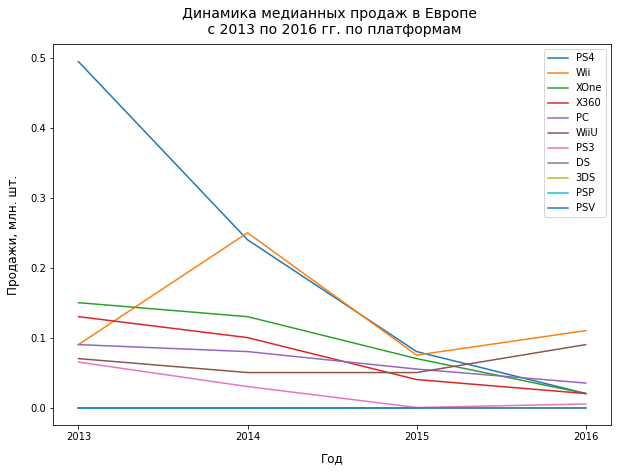

In [91]:
# дополнительно проверим, как ведут себя медианные продажи игр 
# на платформах в Европе в динамике

eu_platform_pivot_median = data_eu.pivot_table(
    index='platform',
    values='eu_sales',
    columns='year_of_release',
    aggfunc='median'
)

eu_platform_pivot_median['total'] = eu_platform_pivot_median.sum(axis=1)
eu_platform_pivot_median = eu_platform_pivot_median.sort_values(by='total', ascending=False)
eu_platform_pivot_median = eu_platform_pivot_median.drop('total', axis=1)
eu_platform_pivot_median.T.plot(figsize=(10, 7))
plt.title('Динамика медианных продаж в Европе \n с 2013 по 2016 гг. по платформам',
         fontsize=14, pad=10)
plt.xlabel('Год', fontsize=12, labelpad=10)
plt.ylabel('Продажи, млн. шт.', fontsize=12, labelpad=10)
plt.xticks([2013, 2014, 2015, 2016])
plt.legend(loc='upper right')
None

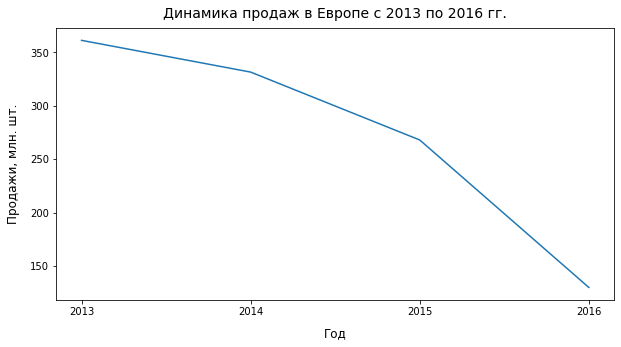

In [92]:
# посмотрим на динамику общих продаж в Европе с 2013 по 2016 гг.

data_eu.groupby('year_of_release')['total_sales'].sum().plot(figsize=(10, 5))
plt.title('Динамика продаж в Европе с 2013 по 2016 гг.', fontsize=14, pad=10)
plt.xlabel('Год', fontsize=12, labelpad=10)
plt.ylabel('Продажи, млн. шт.', fontsize=12, labelpad=10)
plt.xticks([2013, 2014, 2015, 2016])
None

**Продажи игр в Европе за последние 3 года постоянно снижаются**, однако в разбивке по платформам можно заметить интересную тенденцию: несмотря на всеобщее падение медианных продаж, суммарные продажи на некоторых платформах (PS4, XOne) увеличиваются. Это говорит об **увеличении количества игр, производимых и продаваемых на данных платформах**.

#### Топ-5 жанров в Европе

In [93]:
data_eu_genre_pivot = (data_eu
 .pivot_table(index='genre', values='eu_sales', aggfunc='sum')
 .sort_values(by='eu_sales', ascending=False)
)

data_eu_genre_pivot['sales_share'] = (round(data_eu_genre_pivot['eu_sales'] / 
                                         data_eu_genre_pivot['eu_sales'].sum() * 100, 1))
data_eu_genre_pivot.head()

,eu_sales,sales_share
genre,,
Action,118.13,30.1
Shooter,87.86,22.4
Sports,60.52,15.4
Role-Playing,36.97,9.4
Racing,20.19,5.1


Больше всего в Европе с 2013 по 2016 гг. популярностью пользовались игры жанра **Action (30.1% всех продаж в Европе в соответствующий период)**.

В пятёрку наиболее популярных жанров также вошли: **Shooter (22.4%), Sports (15.4%), Role-Playing (9.4%) и Racing (5.1%)**.

Отметим, что рейтинг лучших жанров в Европе практически полностью совпадает с аналогичным рейтингом в Северной Америке - кроме того, очень близки между собой и показатели доли продаж.

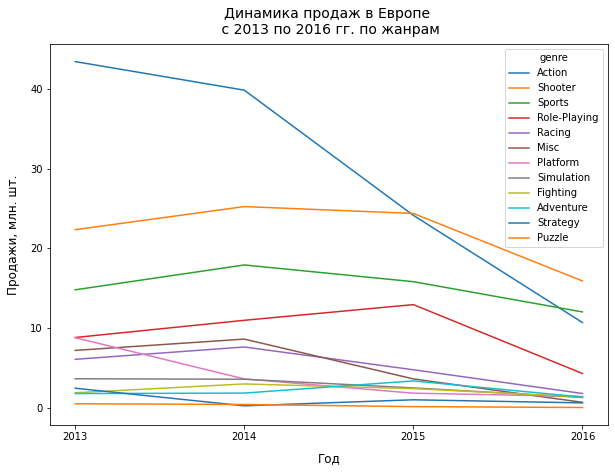

In [94]:
# дополнительно проверим, как ведут себя продажи игр 
# разных жанров в Европе в динамике

eu_genre_pivot = data_eu.pivot_table(
    index='genre',
    values='eu_sales',
    columns='year_of_release',
    aggfunc='sum'
)

eu_genre_pivot['total'] = eu_genre_pivot.sum(axis=1)
eu_genre_pivot = eu_genre_pivot.sort_values(by='total', ascending=False)
eu_genre_pivot = eu_genre_pivot.drop('total', axis=1)
eu_genre_pivot.T.plot(figsize=(10, 7))
plt.title('Динамика продаж в Европе \n с 2013 по 2016 гг. по жанрам',
         fontsize=14, pad=10)
plt.xlabel('Год', fontsize=12, labelpad=10)
plt.ylabel('Продажи, млн. шт.', fontsize=12, labelpad=10)
plt.xticks([2013, 2014, 2015, 2016])
None

Как и в Северной Америке, **продажи игр жанра Action в Европе демонстрируют существенное падение**. Оно **частично компенсируется жанрами Shooter, Sports и Role-Playing**.

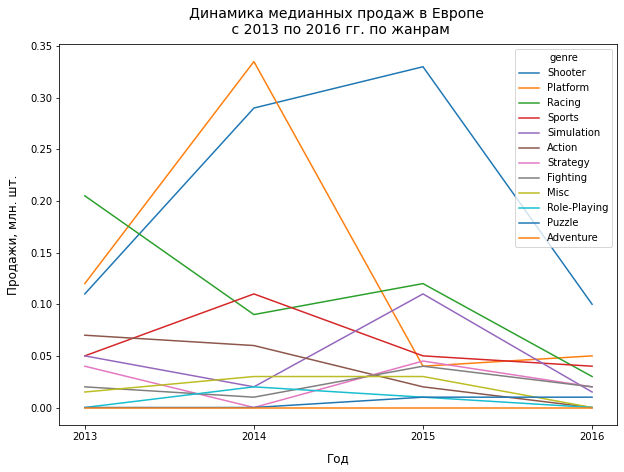

In [95]:
# дополнительно проверим, как ведут себя медианные продажи игр 
# разных жанров в Европе в динамике

eu_genre_pivot_median = data_eu.pivot_table(
    index='genre',
    values='eu_sales',
    columns='year_of_release',
    aggfunc='median'
)

eu_genre_pivot_median['total'] = eu_genre_pivot_median.sum(axis=1)
eu_genre_pivot_median = eu_genre_pivot_median.sort_values(by='total', ascending=False)
eu_genre_pivot_median = eu_genre_pivot_median.drop('total', axis=1)
eu_genre_pivot_median.T.plot(figsize=(10, 7))
plt.title('Динамика медианных продаж в Европе \n с 2013 по 2016 гг. по жанрам',
         fontsize=14, pad=10)
plt.xlabel('Год', fontsize=12, labelpad=10)
plt.ylabel('Продажи, млн. шт.', fontsize=12, labelpad=10)
plt.xticks([2013, 2014, 2015, 2016])
None

В Европе наблюдается та же тенденция медианных продаж с точки зрения жанров: **наиболее перспективными выглядят игры жанра Shooter**.

Игры жанров Sports и Role-Playing, несмотря на большие суммарные продажи, не демонстрируют высокие медианные продажи.

#### Влияние рейтинга ESRB на продажи игр в Европе

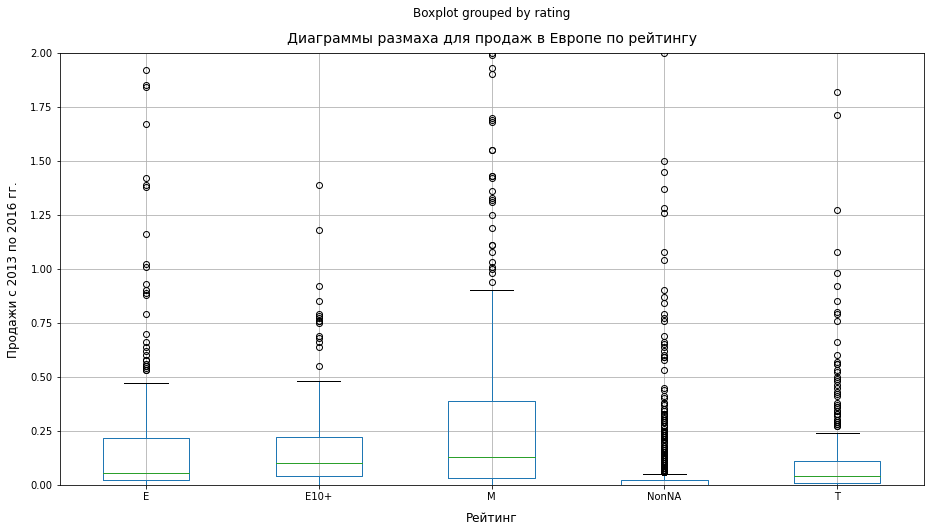

In [96]:
# построим диаграммы размаха переменной продаж в Европе для каждого рейтинга

fig, ax = plt.subplots(figsize=(15, 8))
data_eu.boxplot(column=['eu_sales'], by='rating', ax=ax)
plt.ylim(0, 2)
plt.title('Диаграммы размаха для продаж в Европе по рейтингу', fontsize=14, pad=10)
plt.xlabel('Рейтинг', fontsize=12, labelpad=10)
plt.ylabel('Продажи с 2013 по 2016 гг.', fontsize=12, labelpad=10)
None

Аналогично Северной Америке, **наибольшей популярностью в Европе с 2013 по 2016 гг. пользовались игры рейтинга M (17+)**. Посмотрим на количество проданных игр каждого рейтинга в Европе в этот период.

In [97]:
eu_sales_by_rating = (data_eu
 .pivot_table(index='rating', values='eu_sales', aggfunc='sum')
 .sort_values(by='eu_sales', ascending=False)
)

eu_sales_by_rating['eu_sales_share'] = (round(eu_sales_by_rating['eu_sales'] / 
                                     eu_sales_by_rating['eu_sales'].sum() * 100, 1))
eu_sales_by_rating

,eu_sales,eu_sales_share
rating,,
M,145.32,37.0
E,83.36,21.3
NonNA,78.91,20.1
E10+,42.69,10.9
T,41.95,10.7


**Общие черты** с аналогичным распределением в Северной Америке:
1. **наиболее популярные игры, проданные в Европе с 2013 по 2016 гг., имели рейтинг M с долей продаж 37.0% от всех игр**, проданных в Европе в указанный период (для сравнения: аналогичная доля продаж в Северной Америке составила 37.7%);
2. **доли игр рейтинга E10+ схожи и находятся на 4 месте (10.9% vs. 12.4)**;
3. **на последнем месте по продажам - игры с рейтингом T (10.7% vs. 11.4%)**.

**Отличия:**
1. **игры, произведённые не в США или Канаде, пользуются в Европе чуть меньшей популярностью (20.1% vs. 20.4%)**, занимая 3 место по продажам (в Северной Америке - 2 место);
2. **игры рейтинга E более популярны, чем в Северной Америке (21.3% vs. 18.1%)**.

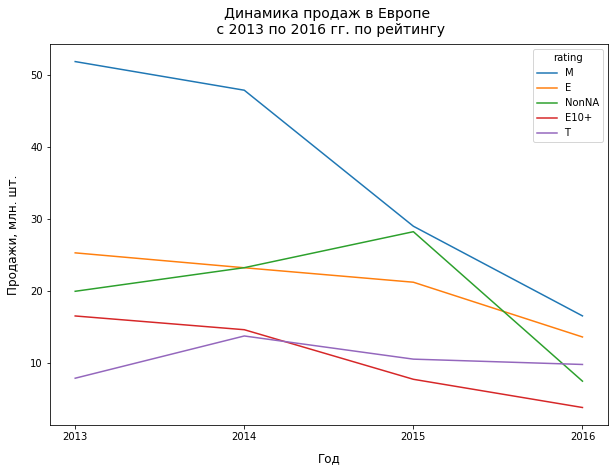

In [98]:
# дополнительно проверим, как ведут себя продажи игр 
# разного рейтинга в Европе в динамике

eu_rating_pivot = data_eu.pivot_table(
    index='rating',
    values='eu_sales',
    columns='year_of_release',
    aggfunc='sum'
)

eu_rating_pivot['total'] = eu_rating_pivot.sum(axis=1)
eu_rating_pivot = eu_rating_pivot.sort_values(by='total', ascending=False)
eu_rating_pivot = eu_rating_pivot.drop('total', axis=1)
eu_rating_pivot.T.plot(figsize=(10, 7))
plt.title('Динамика продаж в Европе \n с 2013 по 2016 гг. по рейтингу',
         fontsize=14, pad=10)
plt.xlabel('Год', fontsize=12, labelpad=10)
plt.ylabel('Продажи, млн. шт.', fontsize=12, labelpad=10)
plt.xticks([2013, 2014, 2015, 2016])
None

Картина выглядит очень похоже на Северную Америку: **игры всех возрастных рейтингов стремительно теряют популярность, при этом наибольшее падение - у игр рейтинга M (17+)**.

**Суммарные продажи игр, произведённых не в США или Канаде, однако, также демонстрируют рост.**

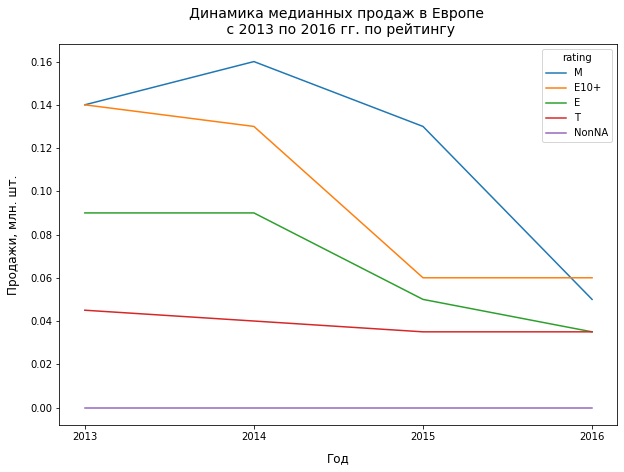

In [99]:
# дополнительно проверим, как ведут себя медианные продажи игр 
# разного рейтинга в Европе в динамике

eu_rating_pivot_median = data_eu.pivot_table(
    index='rating',
    values='eu_sales',
    columns='year_of_release',
    aggfunc='median'
)

eu_rating_pivot_median['total'] = eu_rating_pivot_median.sum(axis=1)
eu_rating_pivot_median = eu_rating_pivot_median.sort_values(by='total', ascending=False)
eu_rating_pivot_median = eu_rating_pivot_median.drop('total', axis=1)
eu_rating_pivot_median.T.plot(figsize=(10, 7))
plt.title('Динамика медианных продаж в Европе \n с 2013 по 2016 гг. по рейтингу',
         fontsize=14, pad=10)
plt.xlabel('Год', fontsize=12, labelpad=10)
plt.ylabel('Продажи, млн. шт.', fontsize=12, labelpad=10)
plt.xticks([2013, 2014, 2015, 2016])
None

По медианным продажам **наибольшее падение заметно у игр рейтинга E10+, хотя уже на данный момент в 2016 г. они опередили продажи игр жанра M**.

В этом смысле **более стабильно выглядят продажи игр рейтинга T**, демонстрируя стабильные медианные продажи, однако пока нельзя назвать игры с этим рейтингом перспективными.

#### Портрет пользователя из Европы

Исходя из анализа, можем сформировать черты, которые характеризуют **портрет среднестатистического пользователя компьютерных игр в Европе**:
1. приобретает игры для платформы PS4;
2. жанр игры - Shooter;
3. рейтинг игры - M (17+) или E10+ (10+).

### JP

#### Топ-5 платформ в Японии

In [100]:
# создадим отдельный датафрейм для игр, проданных в Японии

data_jp = data.drop(['na_sales', 'eu_sales', 'other_sales'], axis=1)
data_jp.head()

,name,platform,year_of_release,genre,jp_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,0.98,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,0.06,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,0.36,NaN,NaN,NonNA,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,4.35,NaN,NaN,NonNA,14.60
42,Grand Theft Auto V,PS4,2014,Action,0.38,97.0,8.3,M,12.62


In [101]:
data_jp_platform_pivot = (data_jp
 .pivot_table(index='platform', values='jp_sales', aggfunc='sum')
 .sort_values(by='jp_sales', ascending=False)
)

data_jp_platform_pivot['sales_share'] = (round(data_jp_platform_pivot['jp_sales'] / 
                                         data_jp_platform_pivot['jp_sales'].sum() * 100, 1))
data_jp_platform_pivot.head()

,jp_sales,sales_share
platform,,
3DS,67.81,48.2
PS3,23.35,16.6
PSV,18.59,13.2
PS4,15.96,11.3
WiiU,10.88,7.7


Наибольшую долю продаж в Японии с 2013 по 2016 гг. составляли игры на платформе **3DS (48.2% от всех продаж в регионе)**. Это неудивительно, т.к. сама платформа была создана именно в Японии.

В пятёрку наиболее популярных платформ в регионе также входят платформы **PS3 (16.6%), PSV (13.2%), PS4 (11.3%) и WiiU (7.7%)**.

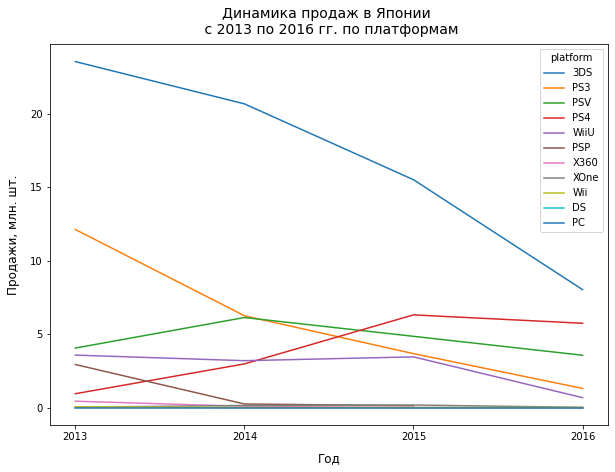

In [102]:
# дополнительно проверим, как ведут себя продажи игр на платформах в Японии в динамике

jp_platform_pivot = data_jp.pivot_table(
    index='platform',
    values='jp_sales',
    columns='year_of_release',
    aggfunc='sum'
)

jp_platform_pivot['total'] = jp_platform_pivot.sum(axis=1)
jp_platform_pivot = jp_platform_pivot.sort_values(by='total', ascending=False)
jp_platform_pivot = jp_platform_pivot.drop('total', axis=1)
jp_platform_pivot.T.plot(figsize=(10, 7))
plt.title('Динамика продаж в Японии \n с 2013 по 2016 гг. по платформам',
         fontsize=14, pad=10)
plt.xlabel('Год', fontsize=12, labelpad=10)
plt.ylabel('Продажи, млн. шт.', fontsize=12, labelpad=10)
plt.xticks([2013, 2014, 2015, 2016])
None

Несмотря на то, что игры на платформе 3DS составляют львиную долю всех продаж в регионе, **продажи игр на этой платформе постоянно падают с 2013 года**.

**Стоит обратить внимание на платформы PS4, PSV и WiiU, которые демонстрируют либо рост (PS4), либо стабильность продаж (PSV и WiiU) с 2013 по 2015 гг.**

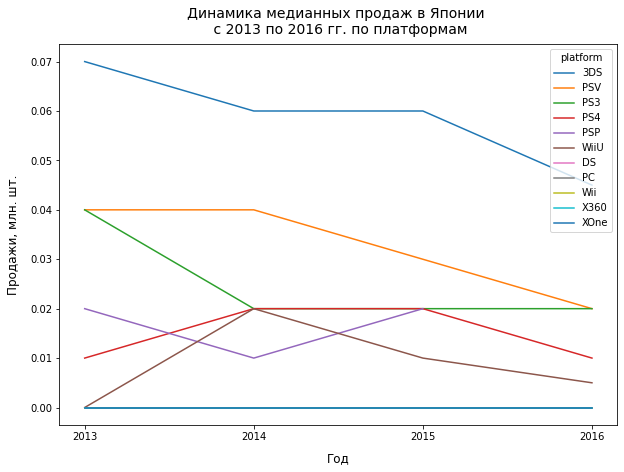

In [103]:
# дополнительно проверим, как ведут себя медианные продажи игр 
# на платформах в Японии в динамике

jp_platform_pivot_median = data_jp.pivot_table(
    index='platform',
    values='jp_sales',
    columns='year_of_release',
    aggfunc='median'
)

jp_platform_pivot_median['total'] = jp_platform_pivot_median.sum(axis=1)
jp_platform_pivot_median = jp_platform_pivot_median.sort_values(by='total', ascending=False)
jp_platform_pivot_median = jp_platform_pivot_median.drop('total', axis=1)
jp_platform_pivot_median.T.plot(figsize=(10, 7))
plt.title('Динамика медианных продаж в Японии \n с 2013 по 2016 гг. по платформам',
         fontsize=14, pad=10)
plt.xlabel('Год', fontsize=12, labelpad=10)
plt.ylabel('Продажи, млн. шт.', fontsize=12, labelpad=10)
plt.xticks([2013, 2014, 2015, 2016])
None

**Платформа 3DS является абсолютным победителем** как по суммарным, так и по медианным продажам, поэтому именно **она является наиболее перспективной на японском рынке**.

#### Топ-5 жанров в Японии

In [104]:
data_jp_genre_pivot = (data_jp
 .pivot_table(index='genre', values='jp_sales', aggfunc='sum')
 .sort_values(by='jp_sales', ascending=False)
)

data_jp_genre_pivot['sales_share'] = (round(data_jp_genre_pivot['jp_sales'] / 
                                         data_jp_genre_pivot['jp_sales'].sum() * 100, 1))
data_jp_genre_pivot.head()

,jp_sales,sales_share
genre,,
Role-Playing,51.04,36.3
Action,40.49,28.8
Misc,9.20,6.5
Fighting,7.65,5.4
Shooter,6.61,4.7


Больше всего в Японии с 2013 по 2016 гг. популярностью пользовались игры жанра **Role-Playing (36.3% всех продаж в Японии в соответствующий период)**. В пятёрку наиболее популярных жанров также вошли: **Action (28.8%), Misc (6.5%), Fighting (5.4%) и Shooter (4.7%)**.

Рейтинг лучших жанров в Японии отличается от топ-5 жанров в Северной Америке и Европе. Жанр **Action** находится среди лидеров, но в перечне появилось несколько новых жанров (**Fighting и Misc**), а первое место заняли игры жанра **Role-Playing**, популярность которых гораздо ниже среди пользователей Северной Америки и Европы.

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkMagenta'>👉 Любой анализ данных требует визуализации его результатов. Табличные данные не всегда информативны. Здесь этого не сделано. Лучше сделать круговые диаграммы, а данные не вошедшие в ТОП просуммировать и вывести отдельной группой "Другие", и по платформам, и по жанрам. Тогда на такой диаграмме хорошо видны все региональные рынки игр с разбиением на платформы/жанры. Какая платформа/жанр занимает какую долю рынка. И наша визуализация несет определенную бизнес-логику, связанную именно с долями рынка занимаемыми платформами/жанрами. А этого не дают другие виды диаграмм. Примерно вот так:</font>
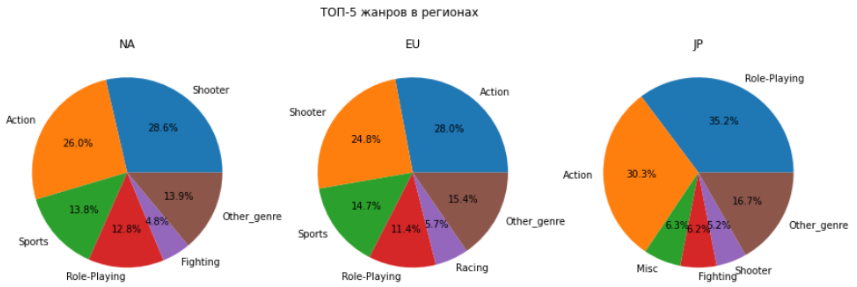

</font><font color='Blue'><b>Комментарий студента</b></font><br>

Добавила визуализацию продаж по платформам, жанрам и рейтингу в п. 4.4. "Результаты анализа портрета пользователей по регионам".

Единственное, не нашла, как можно разместить круги по горизонтали :(

<font color='DarkBlue'><b>Комментарий ревьюера 2</b></font><br>
<font color='DarkGreen'>👌 Методом `plt.subplots()` можно было разместить круговые диаграммы в один ряд. </font>

</font><font color='Blue'><b>Комментарий студента</b></font><br>

Благодарю! Внесла корректировку.

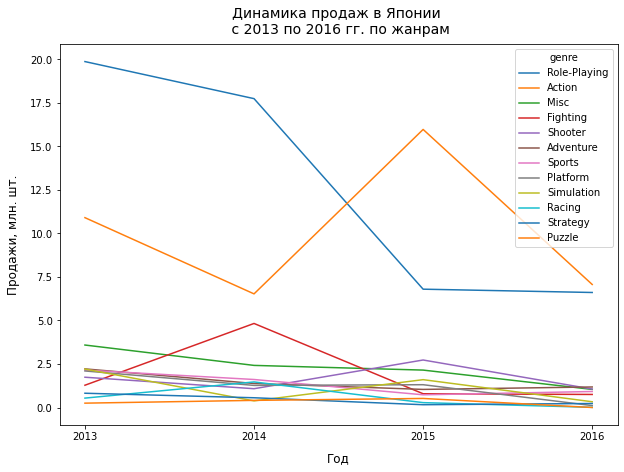

In [105]:
# дополнительно проверим, как ведут себя продажи игр 
# разных жанров в Японии в динамике

jp_genre_pivot = data_jp.pivot_table(
    index='genre',
    values='jp_sales',
    columns='year_of_release',
    aggfunc='sum'
)

jp_genre_pivot['total'] = jp_genre_pivot.sum(axis=1)
jp_genre_pivot = jp_genre_pivot.sort_values(by='total', ascending=False)
jp_genre_pivot = jp_genre_pivot.drop('total', axis=1)
jp_genre_pivot.T.plot(figsize=(10, 7))
plt.title('Динамика продаж в Японии \n с 2013 по 2016 гг. по жанрам',
         fontsize=14, pad=10)
plt.xlabel('Год', fontsize=12, labelpad=10)
plt.ylabel('Продажи, млн. шт.', fontsize=12, labelpad=10)
plt.xticks([2013, 2014, 2015, 2016])
None

Как и с платформами, **японский рынок компьютерных игр отличается от рынков Северной Америки и Европы в разрезе жанров**.

**До 2014 года самым популярным жанром в регионе был Role-Playing**, однако **в 2015 году картина существенно изменилась: на первое место вышли игры жанра Action, а жанр Role-Playing резко упал в популярности**.

В 2014 году также на третье место по продажам в Японии вырвались игры жанра Fighting, но уже в 2015 году оно было занято играми жанра Shooter.

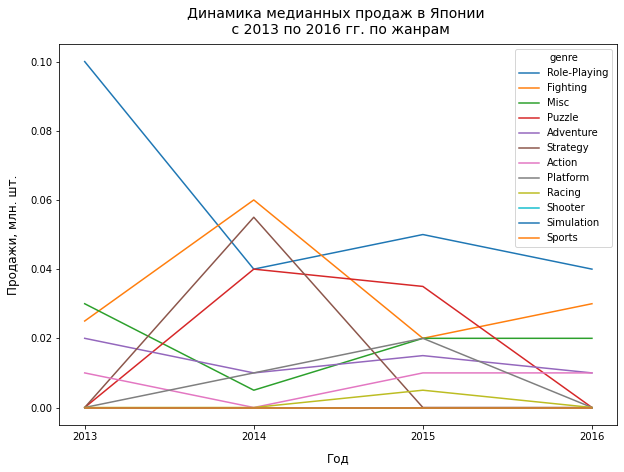

In [106]:
# дополнительно проверим, как ведут себя медианные продажи игр 
# разных жанров в Японии в динамике

jp_genre_pivot_median = data_jp.pivot_table(
    index='genre',
    values='jp_sales',
    columns='year_of_release',
    aggfunc='median'
)

jp_genre_pivot_median['total'] = jp_genre_pivot_median.sum(axis=1)
jp_genre_pivot_median = jp_genre_pivot_median.sort_values(by='total', ascending=False)
jp_genre_pivot_median = jp_genre_pivot_median.drop('total', axis=1)
jp_genre_pivot_median.T.plot(figsize=(10, 7))
plt.title('Динамика медианных продаж в Японии \n с 2013 по 2016 гг. по жанрам',
         fontsize=14, pad=10)
plt.xlabel('Год', fontsize=12, labelpad=10)
plt.ylabel('Продажи, млн. шт.', fontsize=12, labelpad=10)
plt.xticks([2013, 2014, 2015, 2016])
None

Несмотря на всплеск популярности игр жанра Action в Японии в 2015 году, подобные игры не могут похвастаться высокими медианными продажами. Напротив, **игры жанра Role-Playing выглядят более стабильно**.

#### Влияние рейтинга ESRB на продажи игр в Японии

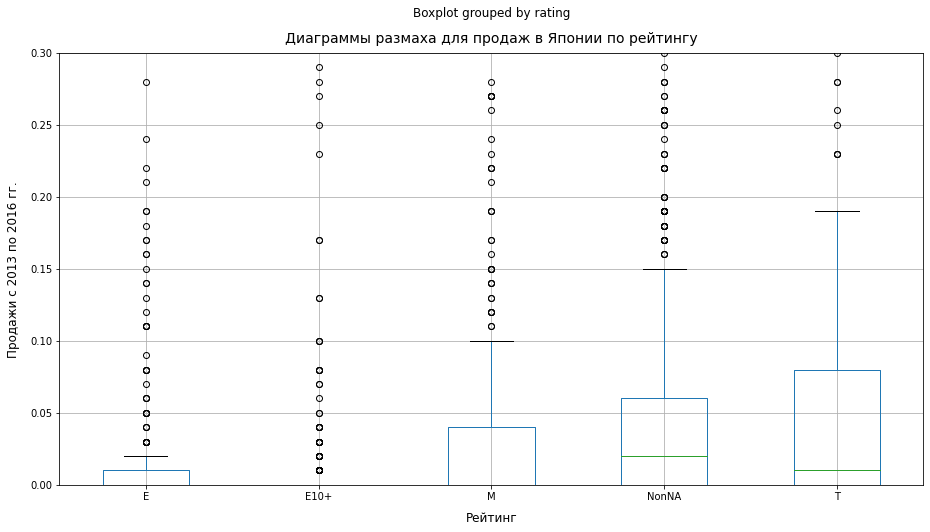

In [107]:
# построим диаграммы размаха переменной продаж в Японии для каждого рейтинга

fig, ax = plt.subplots(figsize=(15, 8))
data_jp.boxplot(column=['jp_sales'], by='rating', ax=ax)
plt.ylim(0, 0.3)
plt.title('Диаграммы размаха для продаж в Японии по рейтингу', fontsize=14, pad=10)
plt.xlabel('Рейтинг', fontsize=12, labelpad=10)
plt.ylabel('Продажи с 2013 по 2016 гг.', fontsize=12, labelpad=10)
None

In [108]:
jp_sales_by_rating = (data_jp
 .pivot_table(index='rating', values='jp_sales', aggfunc='sum')
 .sort_values(by='jp_sales', ascending=False)
)

jp_sales_by_rating['jp_sales_share'] = (round(jp_sales_by_rating['jp_sales'] / 
                                        jp_sales_by_rating['jp_sales'].sum() * 100, 1))
jp_sales_by_rating

,jp_sales,jp_sales_share
rating,,
NonNA,85.05,60.4
T,20.59,14.6
E,15.14,10.8
M,14.11,10.0
E10+,5.89,4.2


<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkMagenta'>👉 При предобработке данных не была поставлена заглушка на пропуски в рейтинге ESRB. И игры без рейтинга оказываются полностью исключенными из анализа. Но продажи именно этих игр могут указать на ключевое различие в регионах.</font><br>
<font color='DarkMagenta'>👉 А проблема в том, что если посмотреть в инете, что из себя представляет рейтинг ESRB, то окажется, что он предназначен для маркировки игр для США и Канады. И логично, что для других регионов он не заполняется. Наша задача смотреть шире на исходный датасет, так как за цифрами находятся реальные бизнес-процессы. И это необходимо учитывать при предобработке данных.  Для этого лучше поставить заглушку и вывести ее при анализе.</font>

</font><font color='Blue'><b>Комментарий студента</b></font><br>

Да, как раз в начале поставила соответствующую заглушку :) Спасибо! Скорректировала вывод по пункту.

In [109]:
# Комментарий ревьюера
temp = data.copy()
print(temp.rating.isna().sum(), temp.rating.isna().sum()/len(temp))
temp.rating.value_counts()

0 0.0


NonNA    977
M        369
T        333
E        302
E10+     252
Name: rating, dtype: int64

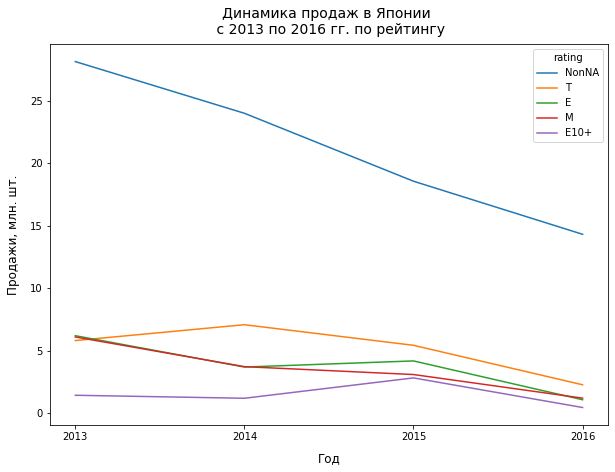

In [110]:
# дополнительно проверим, как ведут себя продажи игр 
# разного рейтинга в Японии в динамике

jp_rating_pivot = data_jp.pivot_table(
    index='rating',
    values='jp_sales',
    columns='year_of_release',
    aggfunc='sum'
)

jp_rating_pivot['total'] = jp_rating_pivot.sum(axis=1)
jp_rating_pivot = jp_rating_pivot.sort_values(by='total', ascending=False)
jp_rating_pivot = jp_rating_pivot.drop('total', axis=1)
jp_rating_pivot.T.plot(figsize=(10, 7))
plt.title('Динамика продаж в Японии \n с 2013 по 2016 гг. по рейтингу',
         fontsize=14, pad=10)
plt.xlabel('Год', fontsize=12, labelpad=10)
plt.ylabel('Продажи, млн. шт.', fontsize=12, labelpad=10)
plt.xticks([2013, 2014, 2015, 2016])
None

Любопытное наблюдение: **более половины суммарных продаж игр в Японии составляют игры, произведённые не в США или Канаде (60.4%)**. Продажи игр с другим рейтингом существенно ниже.

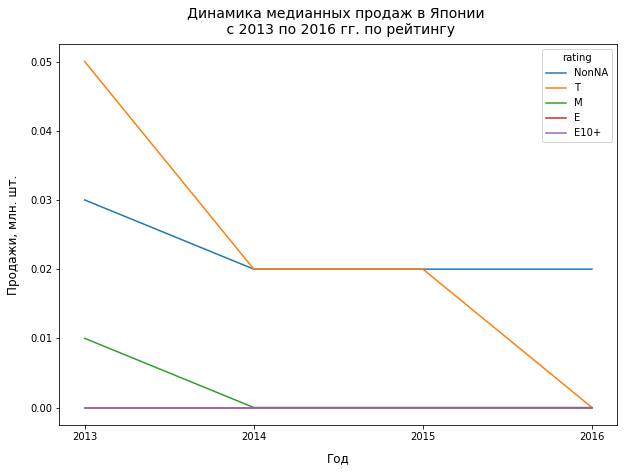

In [111]:
# дополнительно проверим, как ведут себя медианные продажи игр 
# разного рейтинга в Японии в динамике

jp_rating_pivot_median = data_jp.pivot_table(
    index='rating',
    values='jp_sales',
    columns='year_of_release',
    aggfunc='median'
)

jp_rating_pivot_median['total'] = jp_rating_pivot_median.sum(axis=1)
jp_rating_pivot_median = jp_rating_pivot_median.sort_values(by='total', ascending=False)
jp_rating_pivot_median = jp_rating_pivot_median.drop('total', axis=1)
jp_rating_pivot_median.T.plot(figsize=(10, 7))
plt.title('Динамика медианных продаж в Японии \n с 2013 по 2016 гг. по рейтингу',
         fontsize=14, pad=10)
plt.xlabel('Год', fontsize=12, labelpad=10)
plt.ylabel('Продажи, млн. шт.', fontsize=12, labelpad=10)
plt.xticks([2013, 2014, 2015, 2016])
None

Несмотря на значительное превосходство в 2013 году, уже в 2014 году игры с рейтингом T сравнялись по продажам с играми, у которых рейтинга нет, а в 2016 году, даже основываясь на неполных данных, игры, произведённые не в США или Канаде, выглядят абсолютным победителем.

**В Японии, таким образом, гораздо большей популярностью и лучшими перспективами обладают игры, произведённые не в США или Канаде**.

<font color='DarkBlue'><b>Комментарий ревьюера 2</b></font><br>
<font color='DarkGreen'>👌 Это пример, когда пропуски в датасете имеют значение. В Японии свой рейтинг и им мало интересны игры с Северо-Американским рейтингом. А есть еще рейтинги ЕС, отдельно в Германии, в Австралии и т.д. Но у нас нет по ним данных и в данном случае пропуск является признаком, что игра имеет другой рейтинг и выпускалась не в Северной Америке.</font>

In [112]:
# объединим полученные таблицы по регионам

(na_sales_by_rating
 .join([eu_sales_by_rating, jp_sales_by_rating])
)

,na_sales,na_sales_share,eu_sales,eu_sales_share,jp_sales,jp_sales_share
rating,,,,,,
M,165.21,37.7,145.32,37.0,14.11,10.0
NonNA,89.42,20.4,78.91,20.1,85.05,60.4
E,79.05,18.1,83.36,21.3,15.14,10.8
E10+,54.24,12.4,42.69,10.9,5.89,4.2
T,49.79,11.4,41.95,10.7,20.59,14.6


Картина продаж компьютерных игр в Японии с 2013 по 2016 гг. существенно отличается от продаж в Северной Америке и Европе за аналогичный период:
1. **первое место по продажам в Японии заняли игры без рейтинга, т.е. произведённые не в США или Канаде (60.4%);
2. **на втором месте - игры с рейтигом T (13+; 14.6% продаж)**;
3. **игры с рейтингом M (17+) - только на четвёртом месте с долей продаж 10.0%**, что практически в 4 раза ниже аналогичного показателя в Северной Америке и Европе (37.7% и 37.0% соответственно).

Как видим из анализа, **в Японии гораздо большую долю продаж составляют игры, произведённые не в США или Канаде**. Доля продаж таких игр в Северной Америке и Европе меньше примерно в 3 раза.

#### Портрет пользователя из Японии

Исходя из анализа, можем сформировать черты, которые характеризуют **портрет среднестатистического пользователя компьютерных игр в Японии**:
1. приобретает игры для платформы 3DS;
2. жанр игры - Role-Playing;
3. рейтинг игры - без рейтинга (т.е. игры произведены не в США или Канаде).

### Результаты анализа портрета пользователей по регионам

In [113]:
# отобразим визуально разницу распределения продаж игр
# по платформам в разбивке по регионам

# NA
data_na_platform_pivot = data_na_platform_pivot.reset_index()

na_other_sales = pd.Series(['other', 
                            data_na_platform_pivot.loc[5:10, 'na_sales'].sum(),
                            data_na_platform_pivot.loc[5:10, 'sales_share'].sum()],
                            index=['platform', 'na_sales', 'sales_share'])

data_na_platform_pivot = data_na_platform_pivot.append(na_other_sales, ignore_index=True)
data_na_platform_pivot = data_na_platform_pivot.drop(data_na_platform_pivot.index[5:11])


# EU
data_eu_platform_pivot = data_eu_platform_pivot.reset_index()

eu_other_sales = pd.Series(['other', 
                            data_eu_platform_pivot.loc[5:10, 'eu_sales'].sum(),
                            data_eu_platform_pivot.loc[5:10, 'sales_share'].sum()],
                            index=['platform', 'eu_sales', 'sales_share'])

data_eu_platform_pivot = data_eu_platform_pivot.append(eu_other_sales, ignore_index=True)
data_eu_platform_pivot = data_eu_platform_pivot.drop(data_eu_platform_pivot.index[5:11])

# JP
data_jp_platform_pivot = data_jp_platform_pivot.reset_index()

jp_other_sales = pd.Series(['other', 
                            data_jp_platform_pivot.loc[5:10, 'jp_sales'].sum(),
                            data_jp_platform_pivot.loc[5:10, 'sales_share'].sum()],
                            index=['platform', 'jp_sales', 'sales_share'])

data_jp_platform_pivot = data_jp_platform_pivot.append(jp_other_sales, ignore_index=True)
data_jp_platform_pivot = data_jp_platform_pivot.drop(data_jp_platform_pivot.index[5:11])

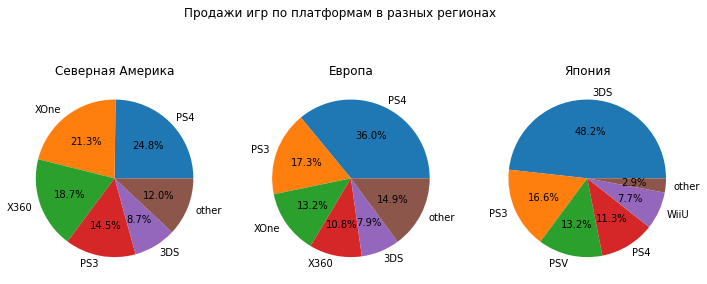

In [114]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle('Продажи игр по платформам в разных регионах')

ax[0].pie(data_na_platform_pivot['sales_share'], labels=data_na_platform_pivot['platform'],
       autopct='%1.1f%%')
ax[0].set_title('Северная Америка')

ax[1].pie(data_eu_platform_pivot['sales_share'], labels=data_eu_platform_pivot['platform'],
       autopct='%1.1f%%')
ax[1].set_title('Европа')

ax[2].pie(data_jp_platform_pivot['sales_share'], labels=data_jp_platform_pivot['platform'],
       autopct='%1.1f%%')
ax[2].set_title('Япония')

plt.show()

In [115]:
# отобразим визуально разницу распределения продаж игр
# по жанрам в разбивке по регионам

# NA
data_na_genre_pivot = data_na_genre_pivot.reset_index()

na_other_sales = pd.Series(['other', 
                            data_na_genre_pivot.loc[5:10, 'na_sales'].sum(),
                            data_na_genre_pivot.loc[5:10, 'sales_share'].sum()],
                            index=['genre', 'na_sales', 'sales_share'])

data_na_genre_pivot = data_na_genre_pivot.append(na_other_sales, ignore_index=True)
data_na_genre_pivot = data_na_genre_pivot.drop(data_na_genre_pivot.index[5:11])


# EU
data_eu_genre_pivot = data_eu_genre_pivot.reset_index()

eu_other_sales = pd.Series(['other', 
                            data_eu_genre_pivot.loc[5:10, 'eu_sales'].sum(),
                            data_eu_genre_pivot.loc[5:10, 'sales_share'].sum()],
                            index=['genre', 'eu_sales', 'sales_share'])

data_eu_genre_pivot = data_eu_genre_pivot.append(eu_other_sales, ignore_index=True)
data_eu_genre_pivot = data_eu_genre_pivot.drop(data_eu_genre_pivot.index[5:11])

# JP
data_jp_genre_pivot = data_jp_genre_pivot.reset_index()

jp_other_sales = pd.Series(['other', 
                            data_jp_genre_pivot.loc[5:10, 'jp_sales'].sum(),
                            data_jp_genre_pivot.loc[5:10, 'sales_share'].sum()],
                            index=['genre', 'jp_sales', 'sales_share'])

data_jp_genre_pivot = data_jp_genre_pivot.append(jp_other_sales, ignore_index=True)
data_jp_genre_pivot = data_jp_genre_pivot.drop(data_jp_genre_pivot.index[5:11])

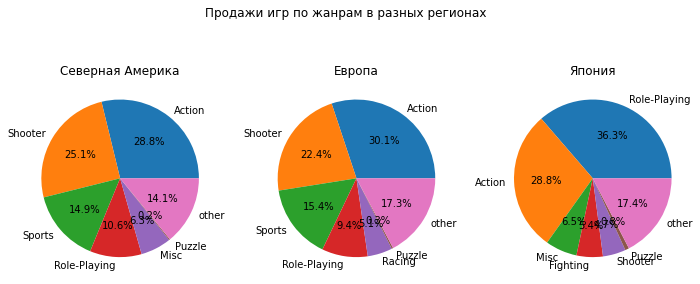

In [116]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle('Продажи игр по жанрам в разных регионах')

ax[0].pie(data_na_genre_pivot['sales_share'], labels=data_na_genre_pivot['genre'],
       autopct='%1.1f%%')
ax[0].set_title('Северная Америка')

ax[1].pie(data_eu_genre_pivot['sales_share'], labels=data_eu_genre_pivot['genre'],
       autopct='%1.1f%%')
ax[1].set_title('Европа')

ax[2].pie(data_jp_genre_pivot['sales_share'], labels=data_jp_genre_pivot['genre'],
       autopct='%1.1f%%')
ax[2].set_title('Япония')

plt.show()

In [117]:
# отобразим визуально разницу распределения продаж игр
# по рейтингу в разбивке по регионам

# NA
na_sales_by_rating = na_sales_by_rating.reset_index()

na_other_sales = pd.Series(['other', 
                            na_sales_by_rating.loc[5:10, 'na_sales'].sum(),
                            na_sales_by_rating.loc[5:10, 'na_sales_share'].sum()],
                            index=['rating', 'na_sales', 'na_sales_share'])

na_sales_by_rating = na_sales_by_rating.append(na_other_sales, ignore_index=True)
na_sales_by_rating = na_sales_by_rating.drop(na_sales_by_rating.index[5:11])


# EU
eu_sales_by_rating = eu_sales_by_rating.reset_index()

eu_other_sales = pd.Series(['other', 
                            eu_sales_by_rating.loc[5:10, 'eu_sales'].sum(),
                            eu_sales_by_rating.loc[5:10, 'eu_sales_share'].sum()],
                            index=['rating', 'eu_sales', 'eu_sales_share'])

eu_sales_by_rating = eu_sales_by_rating.append(eu_other_sales, ignore_index=True)
eu_sales_by_rating = eu_sales_by_rating.drop(eu_sales_by_rating.index[5:11])

# JP
jp_sales_by_rating = jp_sales_by_rating.reset_index()

jp_other_sales = pd.Series(['other', 
                            jp_sales_by_rating.loc[5:10, 'jp_sales'].sum(),
                            jp_sales_by_rating.loc[5:10, 'jp_sales_share'].sum()],
                            index=['rating', 'jp_sales', 'jp_sales_share'])

jp_sales_by_rating = jp_sales_by_rating.append(jp_other_sales, ignore_index=True)
jp_sales_by_rating = jp_sales_by_rating.drop(jp_sales_by_rating.index[5:11])

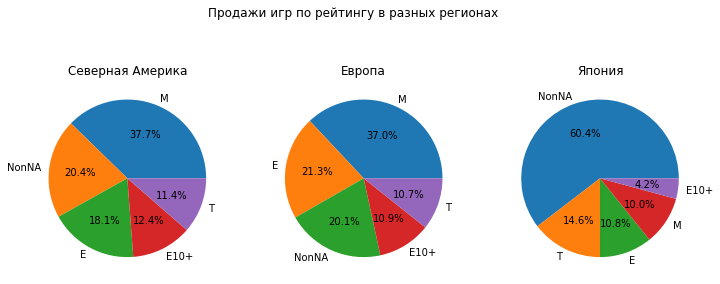

In [118]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle('Продажи игр по рейтингу в разных регионах')

ax[0].pie(na_sales_by_rating['na_sales_share'], labels=na_sales_by_rating['rating'],
       autopct='%1.1f%%')
ax[0].set_title('Северная Америка')

ax[1].pie(eu_sales_by_rating['eu_sales_share'], labels=eu_sales_by_rating['rating'],
       autopct='%1.1f%%')
ax[1].set_title('Европа')

ax[2].pie(jp_sales_by_rating['jp_sales_share'], labels=jp_sales_by_rating['rating'],
       autopct='%1.1f%%')
ax[2].set_title('Япония')

plt.show()

<font color='DarkBlue'><b>Комментарий ревьюера 2</b></font><br>
<font color='DarkGreen'>👌 Молодец, хорошее решение. 👍</font>

</font><font color='Blue'><b>Комментарий студента 2</b></font><br>

Спасибо!

In [119]:
# на основе проведённого анализа можно сделать сводную таблицу 
# с платформами, жанрами и рейтингами, наиболее популярными в разных регионах

# NA
na_platform = (data_na_platform_pivot[data_na_platform_pivot['na_sales'] == 
                        data_na_platform_pivot['na_sales'].max()]['platform'][0])
na_genre = (data_na_genre_pivot[data_na_genre_pivot['na_sales'] == 
                        data_na_genre_pivot['na_sales'].max()]['genre'][0])
na_rating = (na_sales_by_rating[na_sales_by_rating['na_sales'] == 
                        na_sales_by_rating['na_sales'].max()]['rating'][0])

# EU
eu_platform = (data_eu_platform_pivot[data_eu_platform_pivot['eu_sales'] == 
                        data_eu_platform_pivot['eu_sales'].max()]['platform'][0])
eu_genre = (data_eu_genre_pivot[data_eu_genre_pivot['eu_sales'] == 
                        data_eu_genre_pivot['eu_sales'].max()]['genre'][0])
eu_rating = (eu_sales_by_rating[eu_sales_by_rating['eu_sales'] == 
                        eu_sales_by_rating['eu_sales'].max()]['rating'][0])

# JP
jp_platform = (data_jp_platform_pivot[data_jp_platform_pivot['jp_sales'] == 
                        data_jp_platform_pivot['jp_sales'].max()]['platform'][0])
jp_genre = (data_jp_genre_pivot[data_jp_genre_pivot['jp_sales'] == 
                        data_jp_genre_pivot['jp_sales'].max()]['genre'][0])
jp_rating = (jp_sales_by_rating[jp_sales_by_rating['jp_sales'] == 
                        jp_sales_by_rating['jp_sales'].max()]['rating'][0])

# создадим общую сводную таблицу
pd.DataFrame(
    {'platform': [na_platform, eu_platform, jp_platform],
    'genre': [na_genre, eu_genre, jp_genre],
    'rating': [na_rating, eu_rating, jp_rating]},
    index=(['NA', 'EU', 'JP'])
)

,platform,genre,rating
NA,PS4,Action,M
EU,PS4,Action,M
JP,3DS,Role-Playing,NonNA


Стоит, однако, брать во внимание и портреты потенциальных пользователей в каждом регионе:

|        | **platform** | **genre**    | **rating** |
|--------|--------------|--------------|------------|
| **NA** | XOne или PS4 | Shooter      | M (17+)    |
| **EU** | PS4          | Shooter      | M (17+)    |
| **JP** | 3DS          | Role-Playing | NonNA      |

После составления портрета пользователей по регионам можно переходить к статистическому анализу данных.

## Статистический анализ

### Гипотеза 1

**Гипотеза 1:** Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.


Для проведения анализа сформулируем нулевую и альтернативную гипотезы.

**H0:** Средний пользовательский рейтинг игр (*user_score*) на платформе Xbox One равен среднему пользовательскому рейтингу игр на платформе PC.

**H1:** Средний пользовательский рейтинг игр (*user_score*) на платформе Xbox One НЕ равен среднему пользовательскому рейтингу игр на платформе PC.


Гипотеза **о равенстве средних** сформулирована для **двух независимых выборок**, а альтернативная гипотеза - двусторонняя. Следовательно, для тестирования гипотез будет логично применить двусторонний t-test для независимых выборок (**ttest_ind**).

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkGreen'>👌 Хорошо, правильно сформулированы гипотезы.</font>

In [120]:
data_xone = data[data['platform'] == 'XOne']
data_pc = data[data['platform'] == 'PC']

alpha = .05

result = st.ttest_ind(data_xone['user_score'], data_pc['user_score'], nan_policy='omit')

if result.pvalue < alpha:
    print(f'p-value = {round(result.pvalue, 3)}')
    print('Нулевая гипотеза отклоняется в пользу альтернативной')
else:
    print(f'p-value = {round(result.pvalue, 3)}')
    print('Нулевая гипотеза не отклоняется')

p-value = 0.14
Нулевая гипотеза не отклоняется


<font color='DarkBlue'><b>Комментарий ревьюера 2</b></font><br>
<font color='Red'>🛠 А почему не выводим results.pvalue? Забыли?</font>

</font><font color='Blue'><b>Комментарий студента 2</b></font><br>

Точно :( Скорректировала код.

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkGreen'>👌 Хорошо, что использован параметр отфильтровывющий пропуски. 👍</font><br>
<font color='DarkGreen'>👌 Правильно, что для тестирования гипотез использован двусторонний t-тест.</font>

Исходя из результатов тестирования гипотез, не получилось отклонить нулевую гипотезу. Следовательно, делаем вывод: **средний пользовательский рейтинг игр на платформе Xbox One равен среднему пользовательскому рейтингу игр на платформе PC.**

In [121]:
# проверим, на каком уровне находится 
# средний пользовательский рейтинг игр на двух платформах

print('Средний пользовательский рейтинг игр на платформе XOne:', 
      round(data_xone['user_score'].mean(), 2))
print('Средний пользовательский рейтинг игр на платформе PC:', 
      round(data_pc['user_score'].mean(), 2))

Средний пользовательский рейтинг игр на платформе XOne: 6.52
Средний пользовательский рейтинг игр на платформе PC: 6.27


### Гипотеза 2

**Гипотеза 2:** Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

**H0:** Средний пользовательский рейтинг (*user_score*) игр жанра Action равен среднему пользовательскому рейтингу игр жанра Sports.

**H1:** Средний пользовательский рейтинг (*user_score*) игр жанра Action НЕ равен среднему пользовательскому рейтингу игр жанра Sports.

Аналогично предыдущей гипотезе, имеет смысл применить двусторонний t-test для её проверки.

In [122]:
data_action = data[data['genre'] == 'Action']
data_sports = data[data['genre'] == 'Sports']

alpha = .05

result_2 = st.ttest_ind(
    data_action['user_score'], data_sports['user_score'], nan_policy='omit')

if result_2.pvalue < alpha:
    print(f'p-value = {result_2.pvalue}')
    print('Нулевая гипотеза отклоняется в пользу альтернативной')
else:
    print(f'p-value = {result_2.pvalue}')
    print('Нулевая гипотеза не отклоняется')

p-value = 1.0517832389139422e-27
Нулевая гипотеза отклоняется в пользу альтернативной


<font color='DarkBlue'><b>Комментарий ревьюера 2</b></font><br>
<font color='Red'>🛠 И тут не выводим results.pvalue.</font>

</font><font color='Blue'><b>Комментарий студента 2</b></font><br>

Вывела.

<font color='DarkBlue'><b>Комментарий ревьюера 3</b></font><br>
<font color='DarkMagenta'>👉 Зачем формат ограничили тремя знаками?</font>

</font><font color='Blue'><b>Комментарий студента 3</b></font><br>

p-value получается слишком маленький. Вывела полностью, чтобы увидеть.

По результатам проверки второй гипотезы удалось отклонить нулевую гипотезу, т.е. **средний пользовательский рейтинг игр жанра Action НЕ равен среднему пользовательскому рейтингу игр жанра Sports**.

Проверим средние значения пользовательского рейтинга игр двух жанров и с помощью дополнительного одностороннего теста проверим, в чью пользу наблюдается повышенный рейтинг.

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkMagenta'>👉 Лучше было написать, что на имеющихся данных, на уровне значимости 5% есть основания отвергнуть нулевую гипотезу о равенстве средних значений пользовательских рейтингов (отзывов) жанров Action и Sports в пользу альтернативной гипотезы.</font>

</font><font color='Blue'><b>Комментарий студента</b></font><br>

Хорошо, спасибо!

In [123]:
print('Средний пользовательский рейтинг игр жанра Action:', 
      round(data_action['user_score'].mean(), 2))
print('Средний пользовательский рейтинг игр жанра Sports:', 
      round(data_sports['user_score'].mean(), 2))

Средний пользовательский рейтинг игр жанра Action: 6.84
Средний пользовательский рейтинг игр жанра Sports: 5.24


<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkGreen'>👌 Правильно, что показаны дополнительно средние пользовательские рейтинги и по платформам, и по жанрам, как иллюстрации не противоречивости наших гипотез.</font>

In [124]:
alpha = .05

result_3 = st.ttest_ind(
    data_action['user_score'], data_sports['user_score'],
    nan_policy='omit', alternative='greater')

if result_3.pvalue < alpha:
    print('Нулевая гипотеза отклоняется в пользу альтернативной')
else:
    print('Нулевая гипотеза не отклоняется')

Нулевая гипотеза отклоняется в пользу альтернативной


По результатам дополнительного теста было определено, что в генеральной совокупности **пользовательский рейтинг игр жанра Action выше, чем аналогичный показатель для игр жанра Sports**.

## Выводы исследования

### Старые выводы

В ходе проведённого исследования были выявлены следующие **тренды**:

1. наибольшая часть игр была выпущена в период с 2005 по 2011 года, **пик продаж игр приходится на 2009 год. Начиная с этого же года глобальные продажи компании стремительно снижаются**;
2. в "топе" глобальных продаж за последние 5 лет находятся платформы **PS3, X360, PS4, 3DS и XOne**. Однако некоторые из этих платформ, вероятно, уже прошли свой "пик" популярности (PS3, X360, которым на смену пришли PS4 и XOne). **Платформа 3DS, хоть и демонстрирует небольшое снижение глобальных продаж, является самой популярной на японском рынке** (40.8% от всех продаж в регионе);
3. **уверенный рост на глобальном рынке за последние 5 лет демонстрируют 2 платформы: PS4 и XOne**. Первые игры продавались на них в 2013 году, и на протяжении двух лет темпы роста продаж игр на PS4 и XOne позволили перегнать "старые" платформы;
4. практически на всех платформах не наблюдается взаимосвязи между оценкой пользователей и продажами игр на платформе. **Более сильно на продажи влияют оценки критиков, при этом рост продаж имеет скорее экспоненциальный характер**;
5. **наиболее популярными за последние 5 лет являются игры жанра Action, однако с 2013 года они теряют свои позиции на глобальном рынке**. На смену им приходят такие жанры, как Shooter (продажи растут с 2013 по 2015 гг.), Sports и Role-Playing (продажи стабильны с 2013 по 2015 гг.);
6. **средний срок "жизни" игровой платформы составляет 10 лет**, при этом за 5 лет происходит практически полный переход пользователей от одной платформы к другой: за этот срок игры на старой платформе постепенно уходят с рынка, а на новой платформе - набирают популярность;
7. **пользователи игр в Северной Америке и в Европе схожи в своих предпочтениях, в Японии - отличаются**;
8. портрет пользователя в каждом регионе можно разделить на текущий и потенциальный:
    1. **текущий портрет:**
    |                       | **платформа** | **жанр**     | **рейтинг**|
    |-----------------------|---------------|--------------|------------|
    | **Северная Америка**  | X360          | Action       | M (17+)    |
    | **Европа**            | PS3           | Action       | M (17+)    |
    | **Япония**            | 3DS           | Role-Playing | E (0+)     |
    2. **потенциальный портрет:**
    |                      | **платформа**| **жанр**                         | **рейтинг**|
    |----------------------|--------------|----------------------------------|------------|
    | **Северная Америка** | XOne или PS4 | Shooter, Sports или Role-Playing | M (17+)    |
    | **Европа** | PS4                    | Shooter, Sports или Role-Playing | M (17+)    |
    | **Япония** | 3DS, PS4, PSV или WiiU | Action                           | T (13+)    |

Как интернет-магазин "Стримчик" может использовать полученные выводы **в целях планирования дальнейших рекламных кампаний**?
1. дальнейшие рекламные кампании могут быть направлены на повышение продаж на глобально растущих платформах: **XOne или PS4**;
2. имеет смысл **сотрудничество с критиками**: по мере роста их оценки велика вероятность того, что и продажи игры будут расти;
3. с точки зрения жанров наиболее перспективно выглядят игры жанров **Shooter, Sports или Role-Playing**. **Игры жанра Action** постепенно теряют популярность на глобальном рынке, однако т.к. они **ещё находятся на первом месте по продажам**, а также набирают популярность на японском рынке, **их поддержка не должна прекращаться**;
4. целесообразно **диверсифицировать рекламные кампании на рынках Северной Америки, Европы и Японии с учётом портретов потенциальных пользователей** в каждом регионе.

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkMagenta'>👉 Цель исследования понять, на что потратить рекламный бюджет. В исследовании проанализированы игры с разных сторон. Логично, что рекламный отдел ждет данные на какие платформы (1-2 штуки, на большее у нас не хватит рекламного бюджета), с каким жанром, с каким рейтингом ESRB и в каком регионе рекламировать. Стоит ли обращать внимание на отзывы или нет.<br>Вся информация в проекте уже есть, надо просто акцентировать на какие игры тратить рекламный бюджет. Сделаем?</font>

</font><font color='Blue'><b>Комментарий студента</b></font><br>

Добавила ключевые выводы ниже.

### Ключевые выводы

Наибольшим потенциалом обладают инвестиции в игры на разных платформах, разных жанров и рейтинга в различных регионах:
1. **в Северной Америке и Европе:**
    1. платформа - PS4;
    2. жанр - Shooter;
    3. рейтинг - M (17+).
    
2. **в Японии**:
    1. платформа - 3DS;
    2. жанр - Role-Playing;
    3. рейтинг - без рейтинга (т.е. игры, произведённые не в США или Канаде).
    
При планировании дальнейшей стратегии компании стоит также учитывать факторы:
1. на продажи игры **могут положительно влиять оценки критиков**, при этом рост продаж имеет скорее экспоненциальный характер (чем больше оценка критиков - тем больше влияние на продажи). А вот **оценки пользователей с продажами практически не связаны**;
2. средний срок жизни платформы - 7 лет, для лучших платформ - 11.5 лет. **Если с момента запуска платформы прошло больше 7 лет, инвестиции в неё будут менее целесообразны**.

<font color='DarkBlue'><b>Заключительный комментарий ревьюера</b></font><br><br>
<font color='DarkGreen'>👌 Александра, проект отлично структурирован и проработан.<br>Так держать и дальше!<br></font>
<font color='Red'>🛠 Что нужно, что бы сделать проект лучше:</font><br>
<font color='Red'>🛠 Сделать проверку явных и неявных дубликатов. Переделать построение гистограммы в динамике выпуска игр по годам релиза. Переделать обработку пропусков по годам релиза. Выбрать меньший актуальный период для прогнозирования. Анализ влияния отзывов на продажи надо провести по нескольким платформам. В анализе игр по жанрам надо проанализировать медианные значения продаж, построив диаграммы размаха.<br>Обращаю внимание, что после исправления ошибок необходимо будет откорректировать выводы анализа.</font><br>
<font color='DarkMagenta'>👉 При исправлении ошибок и недочетов будут приобретены дополнительный опыт и навыки!</font><br>
<font color='DarkGreen'>👌 Жду окончательный вариант! Успехов.</font>

<font color='DarkBlue'><b>Заключительный комментарий ревьюера 2</b></font><br><br>
<font color='DarkGreen'>👌 Александра, увы, остались еще ошибки.<br></font>
<font color='Red'>🛠 Что нужно доделать:</font><br>
<font color='Red'>🛠 Переделать диаграммы рассеяния при анализе отзывов. При проверке гипотез вывести results.pvalue.<br>Надо будет проверить выводы,  при необходимости  откорректировать.</font><br>
<font color='DarkGreen'>👌 Жду исправленный вариант! Успехов.</font>

</font><font color='Blue'><b>Комментарий студента 2</b></font><br>

Исправила проект по комментариям. Выводы существенно не изменились.

<font color='DarkBlue'><b>Заключительный комментарий ревьюера 3</b></font><br><br>
<font color='DarkGreen'>👌 Александра, остались ошибки.<br></font>
<font color='Red'>🛠 Что нужно сделать:</font><br>
<font color='Red'>🛠 Переделать диаграммы рассеяния при анализе отзывов.</font><br>
<font color='DarkGreen'>👌 Жду исправленный вариант! Успехов.</font>

</font><font color='Blue'><b>Комментарий студента 3</b></font><br>

Исправила проект по комментариям.

<font color='DarkBlue'><b>Заключительный комментарий ревьюера 4 (4-ое ревью из 6-ти возможных)</b></font><br><br>
<font color='DarkGreen'>👌 Александра, остались ошибки.<br></font>
<font color='Red'>🛠 Что нужно сделать:</font><br>
<font color='Red'>🛠 Переделать диаграммы рассеяния при анализе отзывов.</font><br>
<font color='DarkGreen'>👌 Продолжаю ждать исправленный вариант! Успехов.</font>

<font color='DarkBlue'><b>Заключительный комментарий ревьюера 5</b></font><br><br>
<font color='DarkGreen'>👌 Александра! Удалось справиться со всеми подводными камнями в проекте.  Молодец! 😄<br>
Входе выполнения проекта узнали, что не все пропуски просто ошибки сбора данных, а несут свои признаки. Для этого понадобилось за данными датасета увидеть смысл этих данных и бизнес-процессы, которые за ними скрываются. Узнали, что медианы могут дать дополнительную информацию при анализе. Это новые знания и навыки, которые пригодятся в будущем!<br></font>
<font color='DarkGreen'>👌 Теперь, вперед за новыми знаниями и навыками! Удачи! 😉</font>
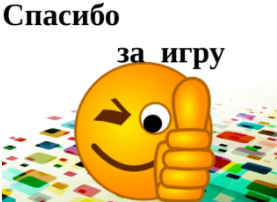